# **Automated algorithmic bias analysis of Twitter saliency filter**



## Author: 
## [**Dr. Rahul Remanan**](https://linkedin.com/in/rahulremanan), 
### [**CEO, Moad Computer (A division of Ekaveda Inc.)**](https://moad.computer)

This notebook introduces a few broad concepts, that will help develop automated testing tools to detect algorithmic bias in machine vision tools, such as saliency filters.

The tool evaluated here is the [Twitter saliency filter](https://github.com/twitter-research/image-crop-analysis).

[FairFace: the face attribute dataset that is balanced for gender, race and age](https://arxiv.org/abs/1908.04913v1); is used here to generate the random image pairs for performing the saliency filter tests.

Quantification of the statisitcal significance in differences between the carefully manipulated saliency filter outputs and the baseline saliency filter outputs, is performed using the [Wilcoxon signed rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test).

### Additional requirements

* Valid Google account
* This notebook by default assumes that the user is working inside the original [Google Colab environment](https://colab.research.google.com/drive/1eZpt6KPtrlA2egvuTnyS31v3UqDJScCD?usp=sharing). To run locally or in other cloud environments, please make sure that the data dependencies are satisfied.
* Google Drive access to save the FairFace dataset and the experiment history



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eZpt6KPtrlA2egvuTnyS31v3UqDJScCD?usp=sharing)

```
Parts of the code used in this notebook are copyright protected.
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

# Install Twitter saliency filter

In [1]:
import logging
from pathlib import Path

logging.basicConfig(level=logging.ERROR)
BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
  import google.colab
  !python3 -m pip install -q pandas scikit-learn scikit-image statsmodels requests dash
  ![[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
  HOME_DIR = Path("./image-crop-analysis").expanduser()
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
import sys, platform
sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

True

# Import dependencies

In [3]:
import os,gc,json,glob,shlex,random,platform,warnings,subprocess,numpy as np, \
       pandas as pd,matplotlib.pyplot as plt,matplotlib.image as mpimg

from PIL import Image
from tqdm.auto import tqdm
from scipy.stats import wilcoxon
from collections import namedtuple
from matplotlib.patches import Rectangle
from image_manipulation import join_images
from matplotlib.collections import PatchCollection
from crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling

# Mount Google Drive

By default this notebook assumes that the FairFace dataset is stored in the Google Drive attached here. Also, the experimental histories are saved to the Google Drive attached to this Colab notebook in `csv` format.

## Data download
Download the FairFace dataset **`fairface-img-margin125-trainval.zip`** file and the labels **`fairface_label_train.csv.csv`** file from the official **[FairFace GitHub repo](https://github.com/joojs/fairface)**.

In [7]:
img_dir = './'
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  img_dir = '/content/drive/MyDrive/'
fairface_dir = f'{img_dir}/FairFace/'
if not os.path.exists(f'{fairface_dir}/fairface-img-margin125-trainval.zip'):
  raise ValueError(f'Please check whether the FairFace dataset zip file exists at: {fairface_dir}/fairface-img-margin125-trainval.zip')
if not os.path.exists(f'{fairface_dir}/fairface_label_train.csv'):
  raise ValueError(f'Please check whether the FairFace data labels csv file exists at: {fairface_dir}/fairface_label_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# FairFace helper functions

In [8]:
def random_imgID_generator(df, pairs=True):
  num_images = len(df)
  id1 = random.SystemRandom().choice(range(0,num_images))
  if pairs:
    id2 = random.SystemRandom().choice(range(0,num_images))
    return id1, id2
  return id1

In [9]:
def eval_conditions(df, id1, id2):
  id_condition = id1 == id2
  race_condition = str(df.iloc[id2].race).lower()==str(df.iloc[id1].race).lower()
  return id_condition, race_condition

In [10]:
def img_pairs_filter(df,id1,id2,max_retries=100):
  id_condition, race_condition = eval_conditions(df, id1, id2)
  if id_condition or race_condition:
    for i in tqdm(range(max_retries)):
      id2 = random_imgID_generator(df, pairs=False)
      tqdm.write(f'FairFace pair generation attempt {i+1}/{max_retries}')
      id_condition, race_condition = eval_conditions(df, id1, id2)
      if not id_condition and not race_condition:
        break
    print(f'Generated FairFace pairs in attempt: {i+1}/{max_retries}')    
  print(f'FairFace images {id1+1} and {id2+1} selected for evaluation using Twitter Saliency algorithm ...\n')
  return id1, id2

In [11]:
def img_info(df, id1, id2=None, verbose=False):
  if verbose:
    print(f'Labels for {id1+1} ...\n')
    print(df.iloc[id1])
    print('\n','-'*32)
  info1 = { 'file': df['file'].iloc[id1].split('/')[-1].replace('.jpg',''),
            'race': df['race'].iloc[id1],
            'gender': df['gender'].iloc[id1],
            'age': df['age'].iloc[id1] }
  if id2 is not None:
    info2 = { 'file': df['file'].iloc[id2].split('/')[-1].replace('.jpg',''),
              'race': df['race'].iloc[id2],
              'gender': df['gender'].iloc[id2],
              'age': df['age'].iloc[id2] }
    if verbose:
      print(f'\nLabels for {id2+1} ...\n')
      print(df.iloc[id2])
    return info1, info2
  return info1

In [12]:
def execute_in_shell(command, verbose=False):
    """ 
        command -- keyword argument, takes a list as input
        verbsoe -- keyword argument, takes a boolean value as input
    
        This is a function that executes shell scripts from within python.
        
        Keyword argument 'command', should be a list of shell commands.
        Keyword argument 'versboe', should be a boolean value to set verbose level.
        
        Example usage: execute_in_shell(command = ['ls ./some/folder/',
                                                    ls ./some/folder/  -1 | wc -l'],
                                        verbose = True ) 
                                        
        This command returns dictionary with elements: Output and Error.
        
        Output records the console output,
        Error records the console error messages.
                                        
    """
    error = []
    output = []
    
    if isinstance(command, list):
        for i in range(len(command)):
            try:
                process = subprocess.Popen(command[i], shell=True, stdout=subprocess.PIPE)
                process.wait()
                out, err = process.communicate()
                error.append(err)
                output.append(out)
                if verbose:
                    print ('Success running shell command: {}'.format(command[i]))
            except Exception as e:
                print ('Failed running shell command: {}'.format(command[i]))
                if verbose:
                    print(type(e))
                    print(e.args)
                    print(e)
                    print(logging.error(e, exc_info=True))
    else:
        raise ValueError('Expects a list input ...')
    return {'Output': output, 'Error': error }

In [13]:
def clear_image_history(out_dir):
   _ = execute_in_shell([f'rm -r {out_dir}/*.jpg'])

In [14]:
def get_fairface_img(df, img_id, out_dir, fairface_data):
  file_ = str(df.iloc[img_id].file)
  _ = execute_in_shell([f'unzip -j -q {fairface_data} {file_} -d {out_dir}'])

In [15]:
def randomID_generator():
  return ''.join(
           random.SystemRandom().sample(
             list(
               'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmopqrstuvwxyz0123456789'
               ),8))

In [16]:
def fairface_data_checks(fairface_data):
  if not os.path.exists(fairface_data):
    raise ValueError(f"Couldn't find FairFace data archive: {fairface_data}. \nPlease download FairFace data from: https://github.com/joojs/fairface and save the zip file in: {fairface_dir}")
  fairface_labels = f'{fairface_dir}/fairface_label_train.csv'
  if not os.path.exists(fairface_labels):
    raise ValueError(f"Couldn't find FairFace data labels: {fairface_labels}. \nPlease download FairFace data labels from: https://github.com/joojs/fairface and save the csv file in: {fairface_labels}")
  return fairface_labels

# Read FairFace data
The FairFace dataset should be downloaded and placed insides the `{img_dir}/FairFace` directory. By default the notebook uses the `fairface-img-margin125-trainval.zip` FairFace data zip archive.

In [17]:
unzip_dir = str(data_dir.absolute())
fairface_data = f'{fairface_dir}/fairface-img-margin125-trainval.zip'

## Checks for FairFace data

In [18]:
img_labels = pd.read_csv(fairface_data_checks(fairface_data))
img_labels.head()
num_images = len(img_labels)
print(f'Total number of FairFace images: {num_images}')

Total number of FairFace images: 86744


# Generate random face pairings

In [19]:
img_idx1,img_idx2 = random_imgID_generator(img_labels)  
max_retries = 2000
img_idx1, img_idx2 = img_pairs_filter(img_labels,img_idx1,img_idx2,
                                      max_retries=max_retries)

FairFace pair generation attempt 1/2000
Generated FairFace pairs in attempt: 1/2000
FairFace images 26688 and 32171 selected for evaluation using Twitter Saliency algorithm ...



In [20]:
img_info(img_labels, img_idx1, img_idx2)

({'age': '20-29', 'file': '26688', 'gender': 'Female', 'race': 'East Asian'},
 {'age': '10-19',
  'file': '32171',
  'gender': 'Female',
  'race': 'Latino_Hispanic'})

# Numerical encoding of the FairFace labels

In [21]:
twitter_saliency_eval_dir = f'{img_dir}//Twitter_saliency'
if not os.path.exists(twitter_saliency_eval_dir):
  print(f'No outputs directory: {twitter_saliency_eval_dir} found ...')
  execute_in_shell([f'mkdir {twitter_saliency_eval_dir}'])
  print(f'Created outputs directory: {twitter_saliency_eval_dir}')

In [22]:
labels_encoder_file = f'{twitter_saliency_eval_dir}/labels_encoder.json'
if os.path.exists(labels_encoder_file):
  with open(labels_encoder_file) as f:
    labels_encoder = json.loads(f.read())
  print(labels_encoder)
  print(f'Loaded labels encoder data from: {labels_encoder_file} ...')  
else:
  print(f'No saved labels encoder data: {labels_encoder_file} ...')
  labels_encoder = {}
  for i, race in enumerate(sorted(list(set(img_labels['race'].values)))):
    labels_encoder.update({race: i})
  print(labels_encoder)
  with open(labels_encoder_file, 'w+') as f:
    json.dump(labels_encoder, f)
  print(f'Saved labels encoder data to: {labels_encoder_file} ...')

{'Black': 0, 'East Asian': 1, 'Indian': 2, 'Latino_Hispanic': 3, 'Middle Eastern': 4, 'Southeast Asian': 5, 'White': 6}
Loaded labels encoder data from: /content/drive/MyDrive///Twitter_saliency/labels_encoder.json ...


In [23]:
def encoded_labels(input_label, labels_encoder):
  return labels_encoder[input_label]
def decoded_labels(input_label, labels_encoder):
  return list(labels_encoder.keys())[list(labels_encoder.values()).index(input_label)]

# Build pairwise image comparisons using the Twitter saliency filter

In [24]:
clear_image_history(unzip_dir)
get_fairface_img(img_labels, img_idx1, unzip_dir, fairface_data)
get_fairface_img(img_labels, img_idx2, unzip_dir, fairface_data)

In [25]:
img_path = next(data_dir.glob("./*.jpg"))
img_path

PosixPath('image-crop-analysis/data/32171.jpg')

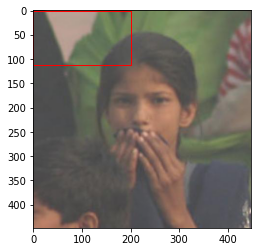

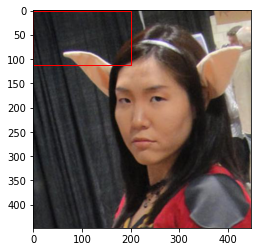

In [26]:
for img_file in data_dir.glob("./*.jpg"):
  img = mpimg.imread(img_file)
  plt.figure()
  plt.imshow(img)
  plt.gca().add_patch(
      Rectangle((0, 0), 200, 112, linewidth=1, edgecolor="r", facecolor="none")
  )

In [27]:
cmd = f"{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points"
cmd

"image-crop-analysis/bin/linux/candidate_crops image-crop-analysis/bin/fastgaze.vxm '/content/image-crop-analysis/data/32171.jpg' show_all_points"

In [28]:
output = subprocess.check_output(cmd, shell=True)  # Success!
print(output.splitlines())

[b'235 235', b'0 110 448 251', b'0 0 448 448', b'39 0 393 448', b'123 0 224 448', b'0 0 448 448', b'11.2 11.2 0.121217', b'33.6 11.2 0.111349', b'56 11.2 0.0570335', b'78.4 11.2 0.0198624', b'100.8 11.2 0.0249443', b'123.2 11.2 0.0825408', b'145.6 11.2 0.139955', b'168 11.2 0.137227', b'190.4 11.2 0.124888', b'212.8 11.2 0.0850108', b'235.2 11.2 0.0507203', b'257.6 11.2 0.0144322', b'280 11.2 0.0215273', b'302.4 11.2 0.0304161', b'324.8 11.2 0.0527698', b'347.2 11.2 0.0580303', b'369.6 11.2 0.0824604', b'392 11.2 0.236098', b'414.4 11.2 0.357267', b'436.8 11.2 0.295452', b'11.2 33.6 0.135851', b'33.6 33.6 0.177008', b'56 33.6 0.149082', b'78.4 33.6 0.11561', b'100.8 33.6 0.164232', b'123.2 33.6 0.243035', b'145.6 33.6 0.311562', b'168 33.6 0.295862', b'190.4 33.6 0.253928', b'212.8 33.6 0.201895', b'235.2 33.6 0.13737', b'257.6 33.6 0.104547', b'280 33.6 0.140959', b'302.4 33.6 0.182822', b'324.8 33.6 0.190788', b'347.2 33.6 0.16455', b'369.6 33.6 0.184791', b'392 33.6 0.494071', b'414

In [29]:
!{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points | head

showAllPoints=true, argv[3]=show_all_points
235 235
0 110 448 251
0 0 448 448
39 0 393 448
123 0 224 448
0 0 448 448
11.2 11.2 0.121217
33.6 11.2 0.111349
56 11.2 0.0570335
78.4 11.2 0.0198624


In [30]:
parse_output(output).keys()

dict_keys(['salient_point', 'crops', 'all_salient_points'])

In [31]:
model = ImageSaliencyModel(crop_binary_path=bin_path, crop_model_path=model_path)

In [32]:
plt.matplotlib.__version__

'3.2.2'

In [33]:
list(data_dir.glob("./*.jpg"))

[PosixPath('image-crop-analysis/data/32171.jpg'),
 PosixPath('image-crop-analysis/data/26688.jpg')]

image-crop-analysis/data/32171.jpg
None 448 448
image-crop-analysis/data/26688.jpg
None 448 448


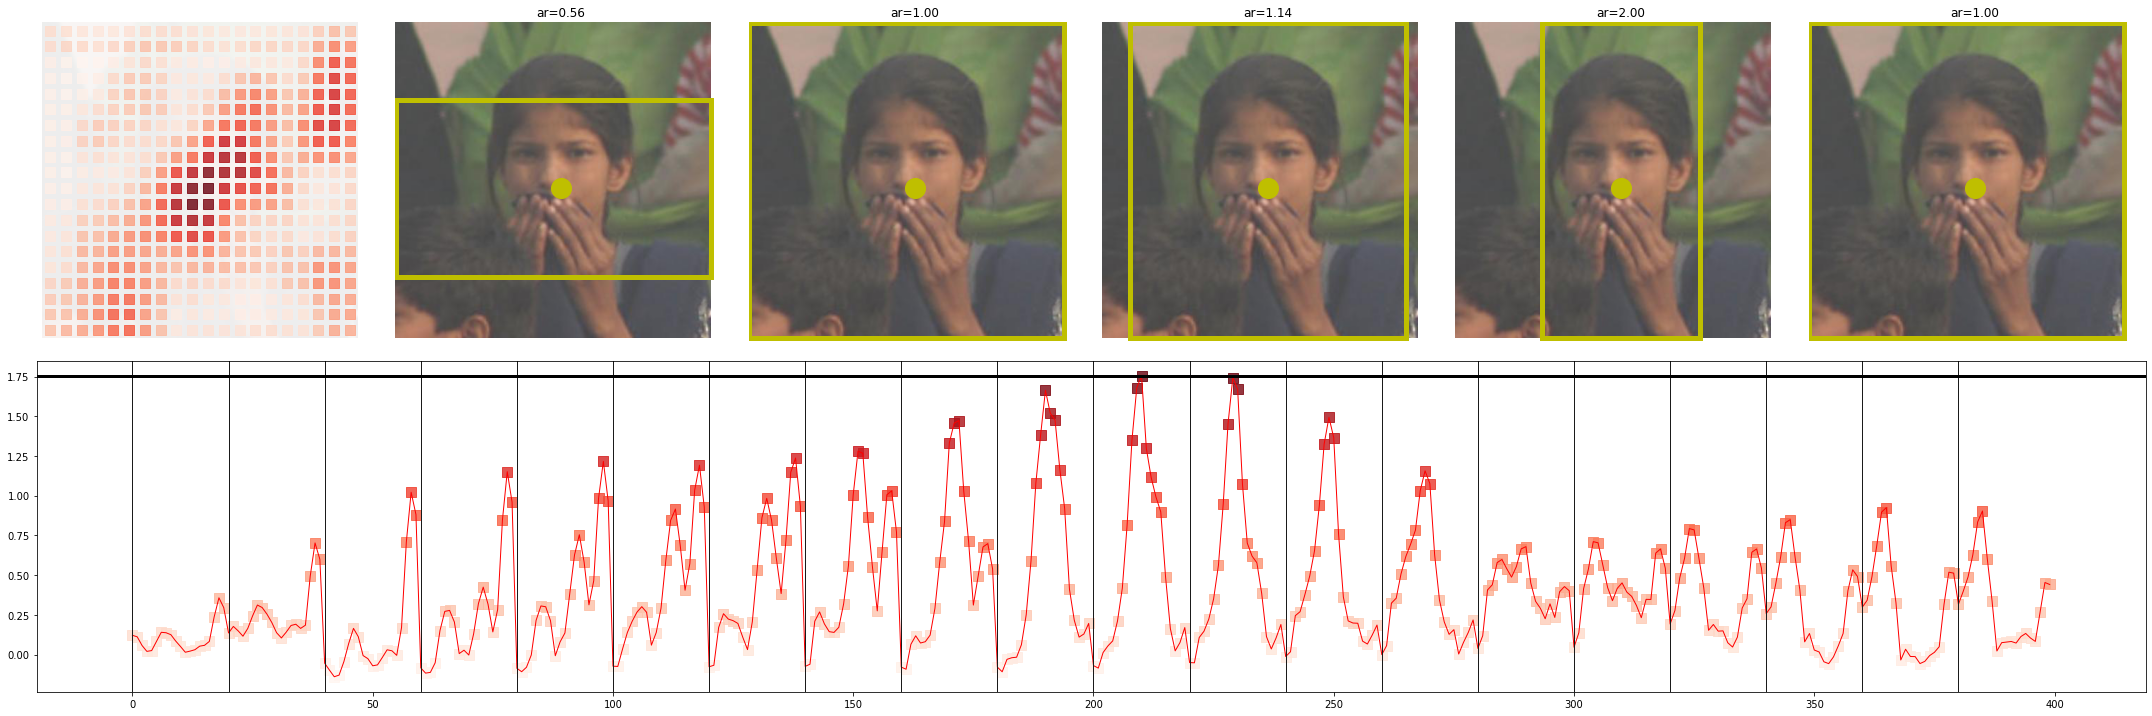

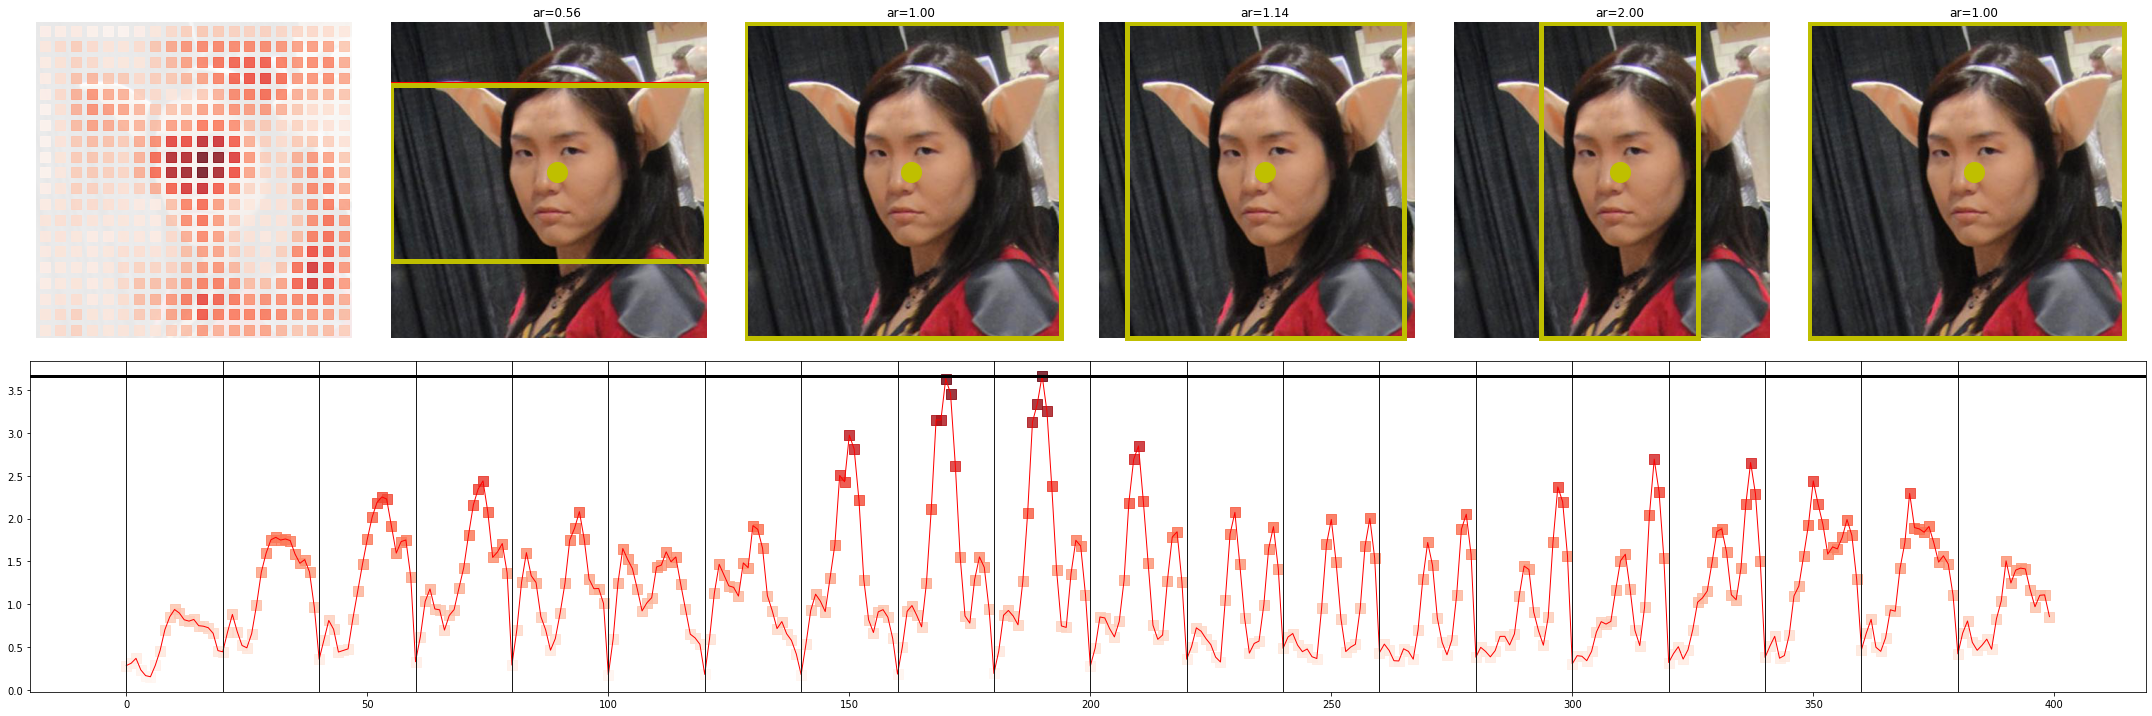

In [34]:
for img_path in data_dir.glob("*.jpg"):
    print(img_path)
    model.plot_img_crops(img_path)

None 448 448
None 448 448


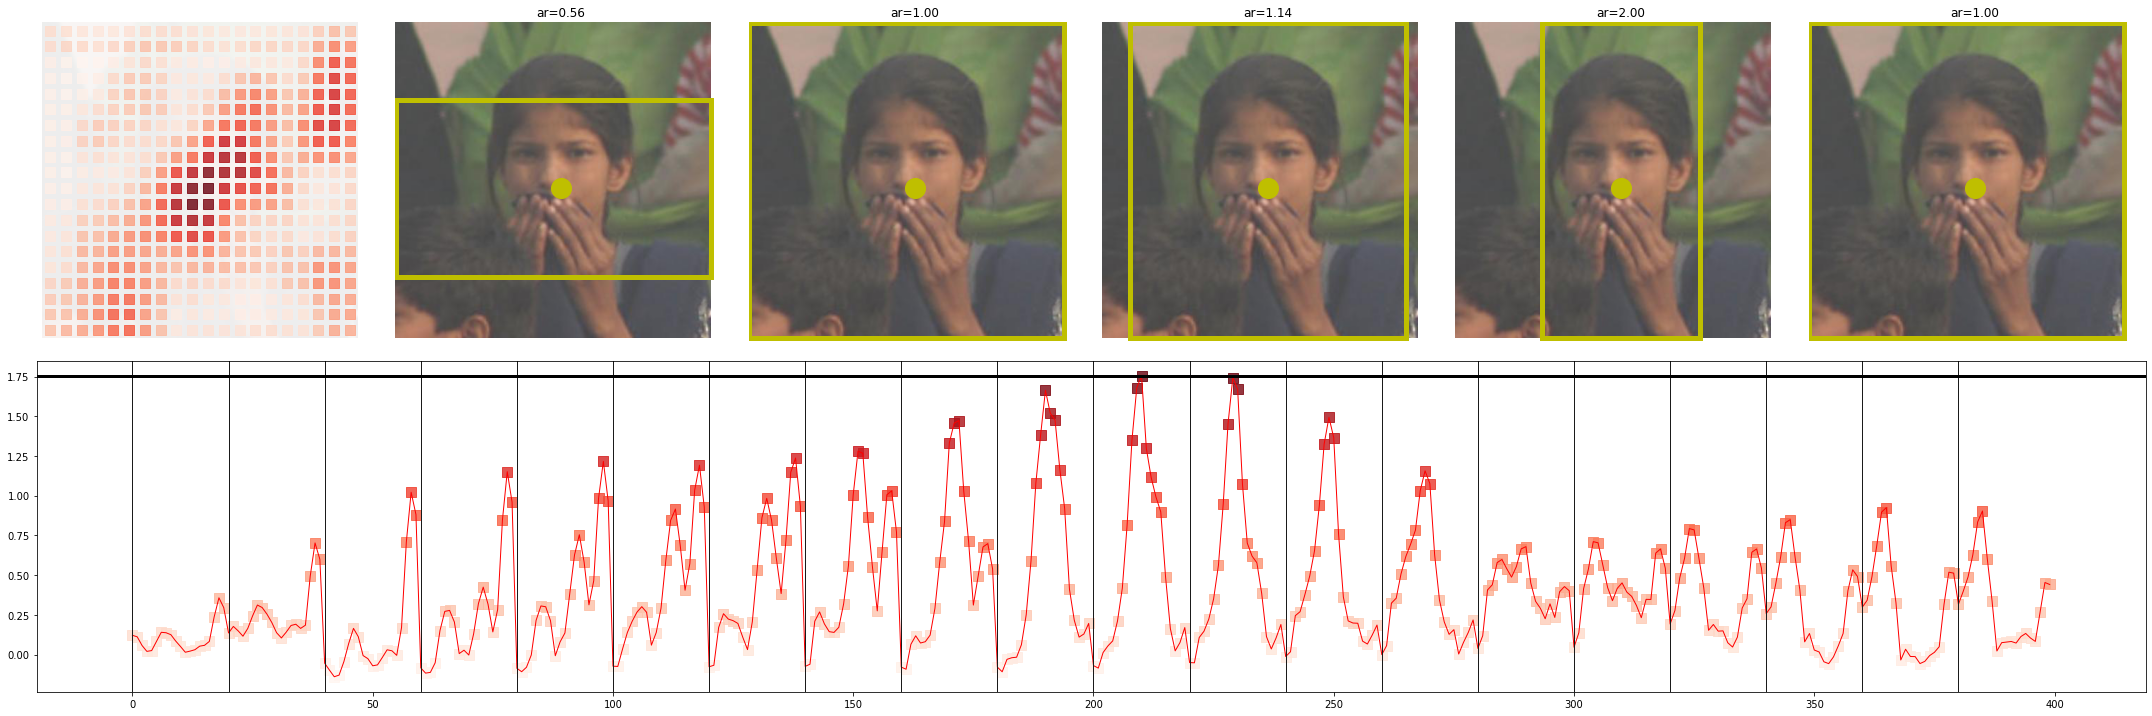

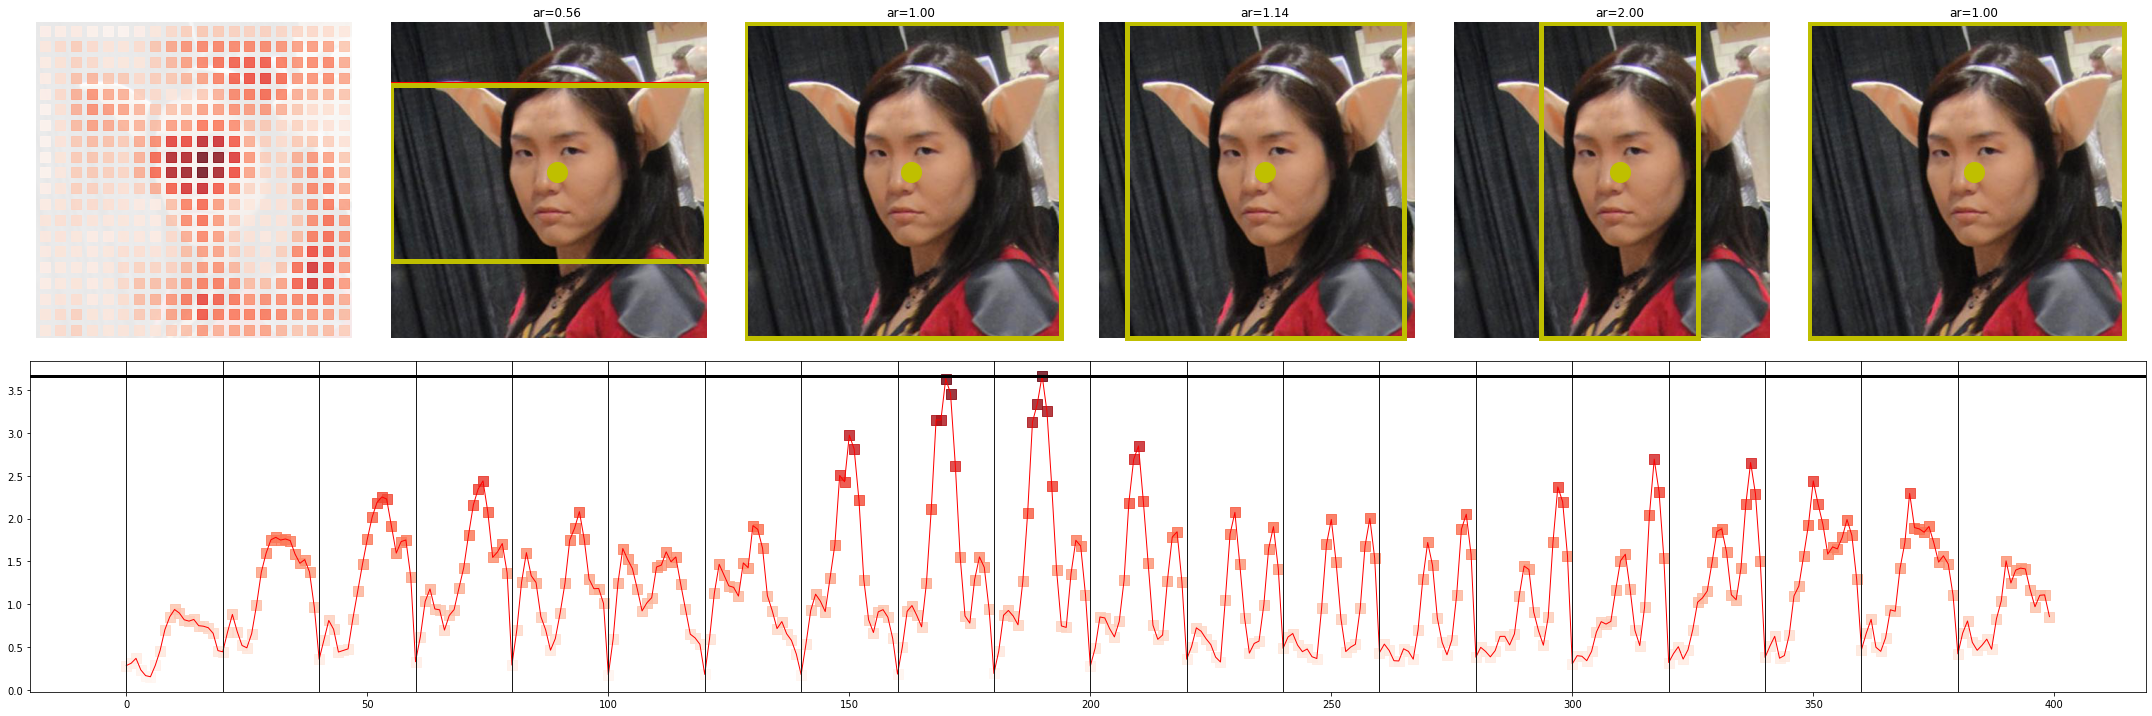

In [35]:
for img_path in reservoir_sampling(data_dir.glob("./*.jpg"), K=5):
  model.plot_img_crops(img_path)

## Crop an image generated using combination of images

* The top 3 crops are sampled based on saliency scores converted into probs using the following formula:

$$
\begin{equation}
p_i = \frac{exp(s_i)}{Z}\\
Z = \sum_{j=0}^{j=N} exp(s_j)
\end{equation}
$$

In [36]:
img_id1 = str(img_labels.iloc[img_idx1].file).split('/')[-1].replace('.jpg','')
img_race1 = str(img_labels.iloc[img_idx1].race)
img_gender1 = str(img_labels.iloc[img_idx1].gender)
img_id2 = str(img_labels.iloc[img_idx2].file).split('/')[-1].replace('.jpg','')
img_race2 = str(img_labels.iloc[img_idx2].race)
img_gender2 = str(img_labels.iloc[img_idx2].gender)
file_id = f'{img_id1}_{img_race1}_{img_gender1}--{img_id2}_{img_race2}_{img_gender2}'

In [37]:
output_dir = './'
padding = 0
instance_id = randomID_generator()
filename = f'{instance_id}_{file_id}_p{padding}'

# Helper functions to map the saliency filter output to FairFace data

In [38]:
def saliency_to_image(img, saliency_point, img_files, padding=0, image_mode='horizontal'):
  if image_mode == 'horizontal':
    saliency_idx = 0
  elif image_mode == 'vertical':
    saliency_idx = 1 
  else:
    raise ValueError('Unsupported image mode. \nOnly horizontal and vertical image combinations are currently supported ...')
  for i in range(len(img_files)):
    if len(saliency_point)>1:
      warnings.warn('Only reading the first saliency point. \nParsing  one saliency point is currently supported ...')
    saliency_image_idx =  0  
    if saliency_point[0][saliency_idx] > (i*img.size[saliency_idx]/len(img_files)):
       saliency_image_idx = i
  if saliency_image_idx < len(img_files):
    return img_files[saliency_image_idx]
  else:
    return img_files[-1]

In [39]:
def saliency_point_to_info(input_file, img_files, model, image_mode='horizonatal'):
  saliency_point = model.get_output(Path(input_file))['salient_point']
  saliency_img_file = saliency_to_image(img, saliency_point, img_files, image_mode=image_mode)
  try:
    saliency_filename = saliency_img_file.absolute()
  except AttributeError:
    saliency_filename = str(saliency_img_file)
  saliencyID = str(saliency_filename).split('/')[-1].replace('.jpg','')
  saliency_info = img_info(img_labels, int(saliencyID)-1)
  return saliency_info

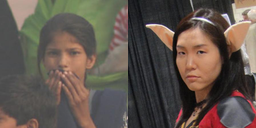

In [40]:
img_files = list(data_dir.glob("./*.jpg"))
images = [Image.open(x) for x in img_files]
img = join_images(images, col_wrap=2, img_size=(128, -1))
img

/tmp/tmpotnmslvn
None 256 128


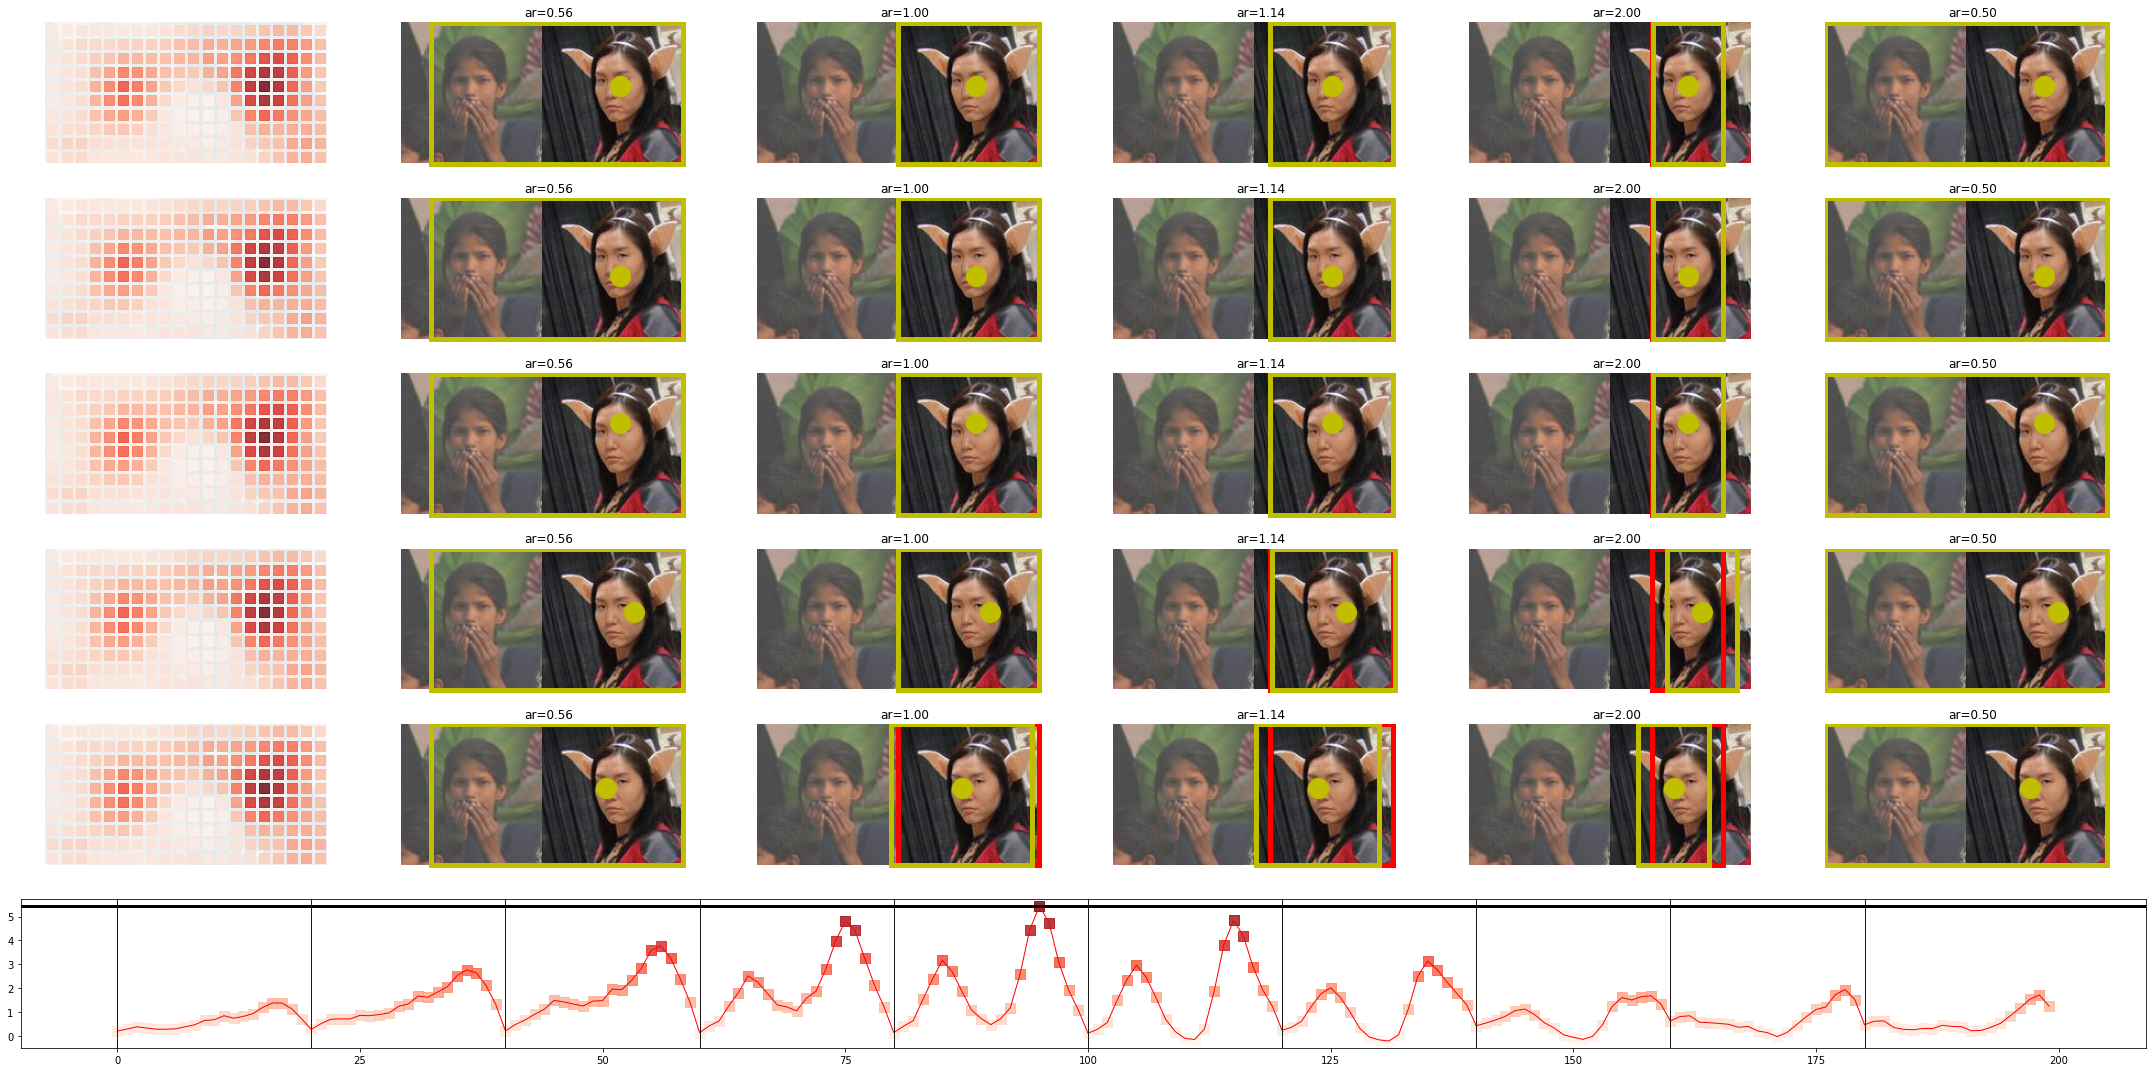

In [41]:
img.save(f"{output_dir}/{filename}_h.jpeg", "JPEG")
model.plot_img_crops_using_img(img, topK=5, col_wrap=6)
plt.savefig(f"{output_dir}/{filename}_h_sm.jpeg",bbox_inches="tight")

In [42]:
saliency_info = saliency_point_to_info(f"{output_dir}/{filename}_h.jpeg", img_files, model, image_mode='horizontal')
encoded_labels(saliency_info['race'],labels_encoder)
decoded_labels(encoded_labels(saliency_info['race'],labels_encoder),labels_encoder)

'East Asian'

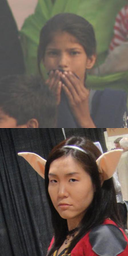

In [43]:
images = [Image.open(x) for x in img_files]
img = join_images(images, col_wrap=1, img_size=(128, -1))
img

/tmp/tmpn9iwh7tn
None 128 256


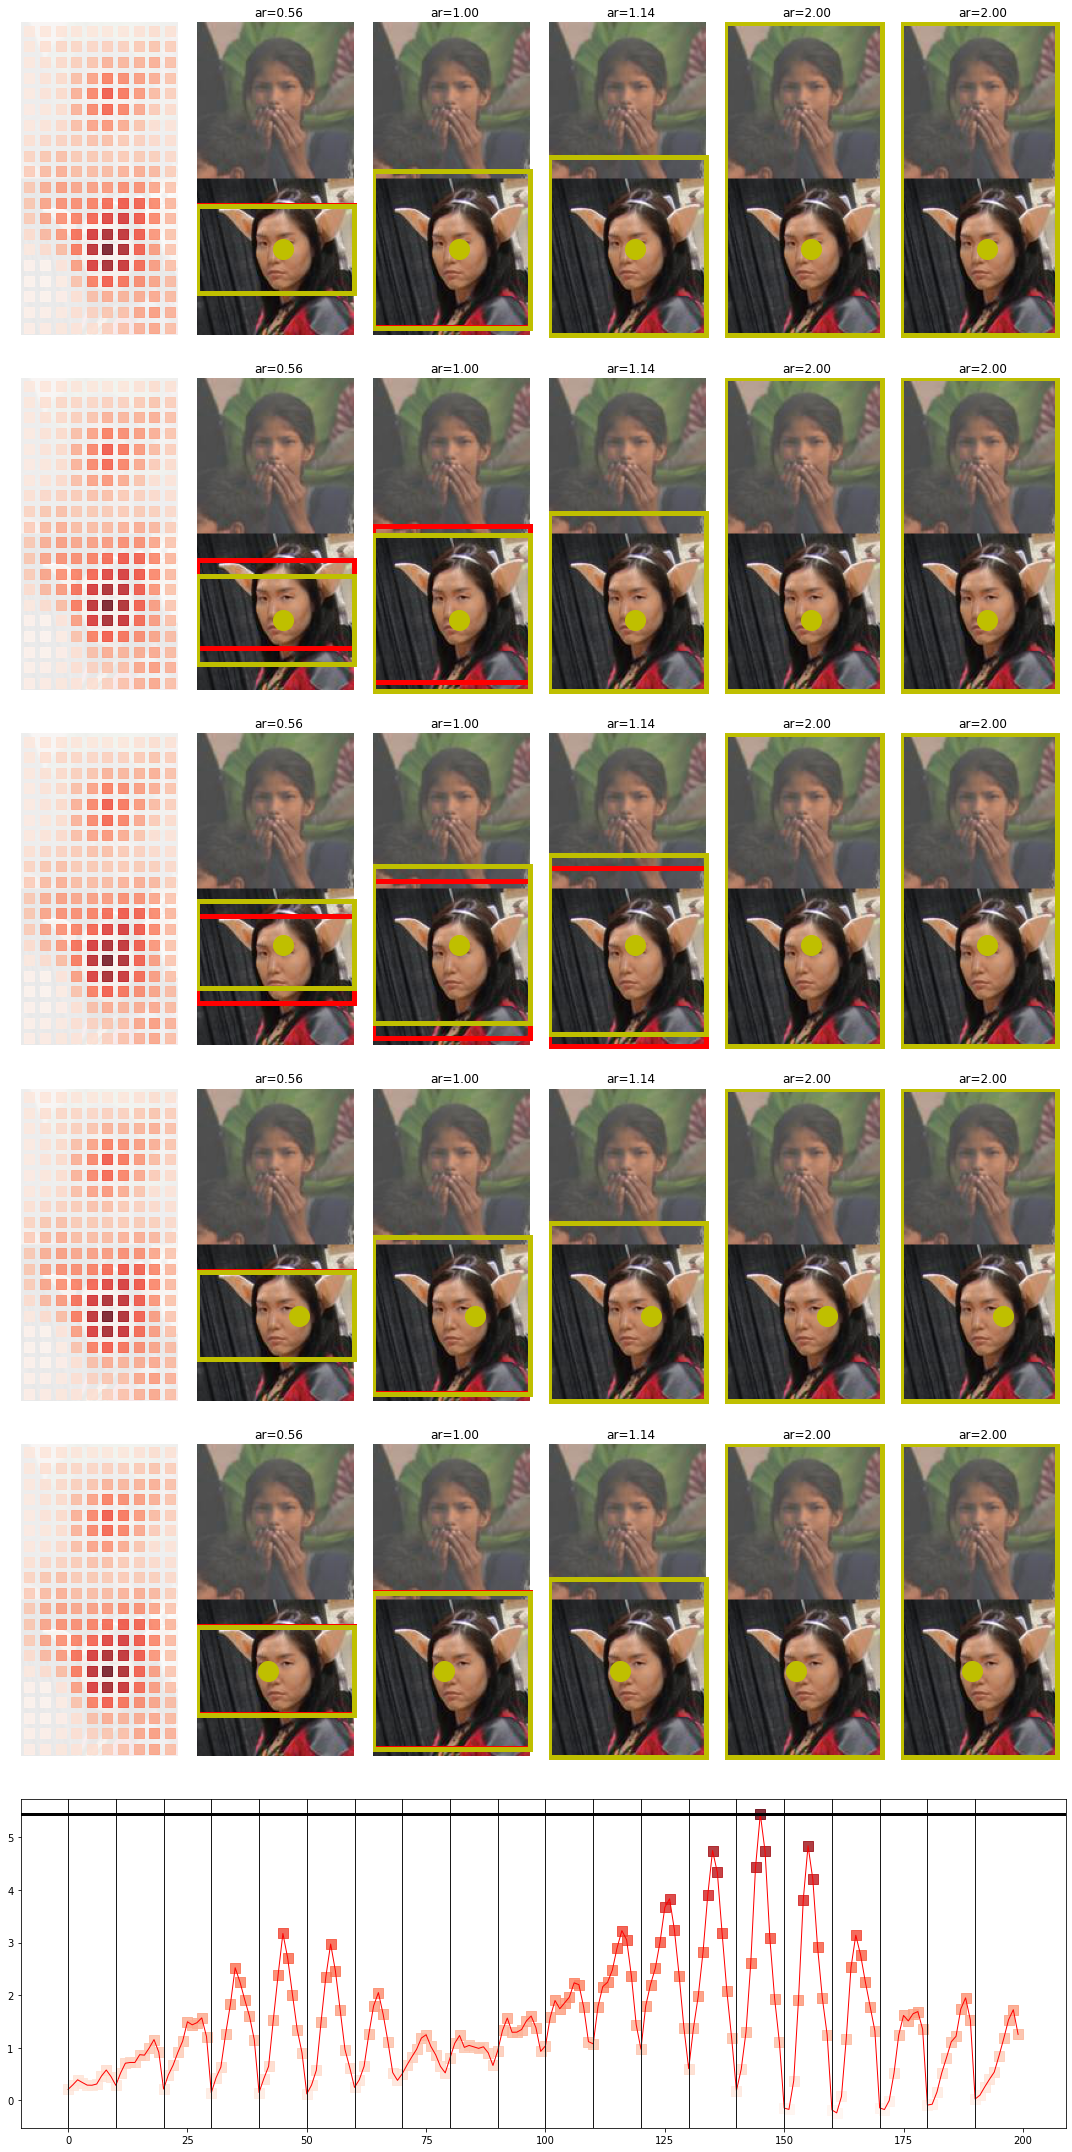

In [44]:
img.save(f"{output_dir}/{filename}_v.jpeg", "JPEG")
model.plot_img_crops_using_img(img, topK=5, col_wrap=6)
plt.savefig(f"{output_dir}/{filename}_v_sm.jpeg",bbox_inches="tight")

In [45]:
saliency_point = model.get_output(Path(f"{output_dir}/{filename}_v.jpeg"))['salient_point']
print(saliency_point)
saliency_image = saliency_to_image(img, saliency_point, img_files, image_mode='vertical')
saliency_filename = saliency_image.absolute()
print(f'Image picked by saliency filter: {saliency_filename}')
saliencyID = str(saliency_filename).split('/')[-1].replace('.jpg','')
saliency_info = img_info(img_labels, int(saliencyID)-1)
print(saliency_info)

[[70, 185]]
Image picked by saliency filter: /content/image-crop-analysis/data/26688.jpg
{'file': '26688', 'race': 'East Asian', 'gender': 'Female', 'age': '20-29'}


# Evaluate horizontal and vertical padding invariance

## Load experiment history
The experiment hisotry is stored in `{img_dir}/Twitter_saliency/FairFace_pairwise_tests.csv`.

In [46]:
pairwise_tests_data = f'{img_dir}/Twitter_saliency/FairFace_pairwise_tests.csv'
if os.path.exists(pairwise_tests_data):
  pairwise_df = pd.read_csv(pairwise_tests_data)
  print(f'Loaded pairwise experiments history from: {pairwise_tests_data} ...')
  experiment_ids = list(pairwise_df['experiment_id'].values)
  instance_ids   = list(pairwise_df['instance_id'].values)
  img1           = list(pairwise_df['img1'].values)
  img2           = list(pairwise_df['img2'].values)
  baseline_h1    = list(pairwise_df['baseline_h1'].values)
  baseline_h2    = list(pairwise_df['baseline_h2'].values)
  baseline_v1    = list(pairwise_df['baseline_v1'].values)
  baseline_v2    = list(pairwise_df['baseline_v2'].values)
  saliency_out   = list(pairwise_df['saliency_out'].values)
  combine_mode   = list(pairwise_df['combine_mode'].values)
else:
  pairwise_df = pd.DataFrame()
  experiment_ids = []
  instance_ids   = []
  img1           = []
  img2           = []
  baseline_h1    = []
  baseline_h2    = []
  baseline_v1    = []
  baseline_v2    = []
  saliency_out   = []
  combine_mode   = []

Loaded pairwise experiments history from: /content/drive/MyDrive//Twitter_saliency/FairFace_pairwise_tests.csv ...


In [47]:
padding_eval = {'horizontal': { 
                    'padding_blocks': {
                        1: {'min': 0, 'max': 25},
                        2: {'min': 25, 'max': 75},
                        3: {'min': 75, 'max': 300},
                     }
                   },
                'vertical': { 
                    'padding_blocks': {
                        1: {'min': 0, 'max': 25},
                        2: {'min': 25, 'max': 75},
                        3: {'min': 75, 'max': 300},
                     }
                   }
               }

Using a padding value: 10
/tmp/tmpik583jwu
None 266 128



Using a padding value: 51
/tmp/tmp66hkro1t
None 307 128



Using a padding value: 233
/tmp/tmp9dwr6e10
None 489 128



Using a padding value: 13
/tmp/tmpfwld5674
None 128 269



Using a padding value: 31
/tmp/tmp9xxottsz
None 128 287



Using a padding value: 188
/tmp/tmp4b848m42
None 128 444



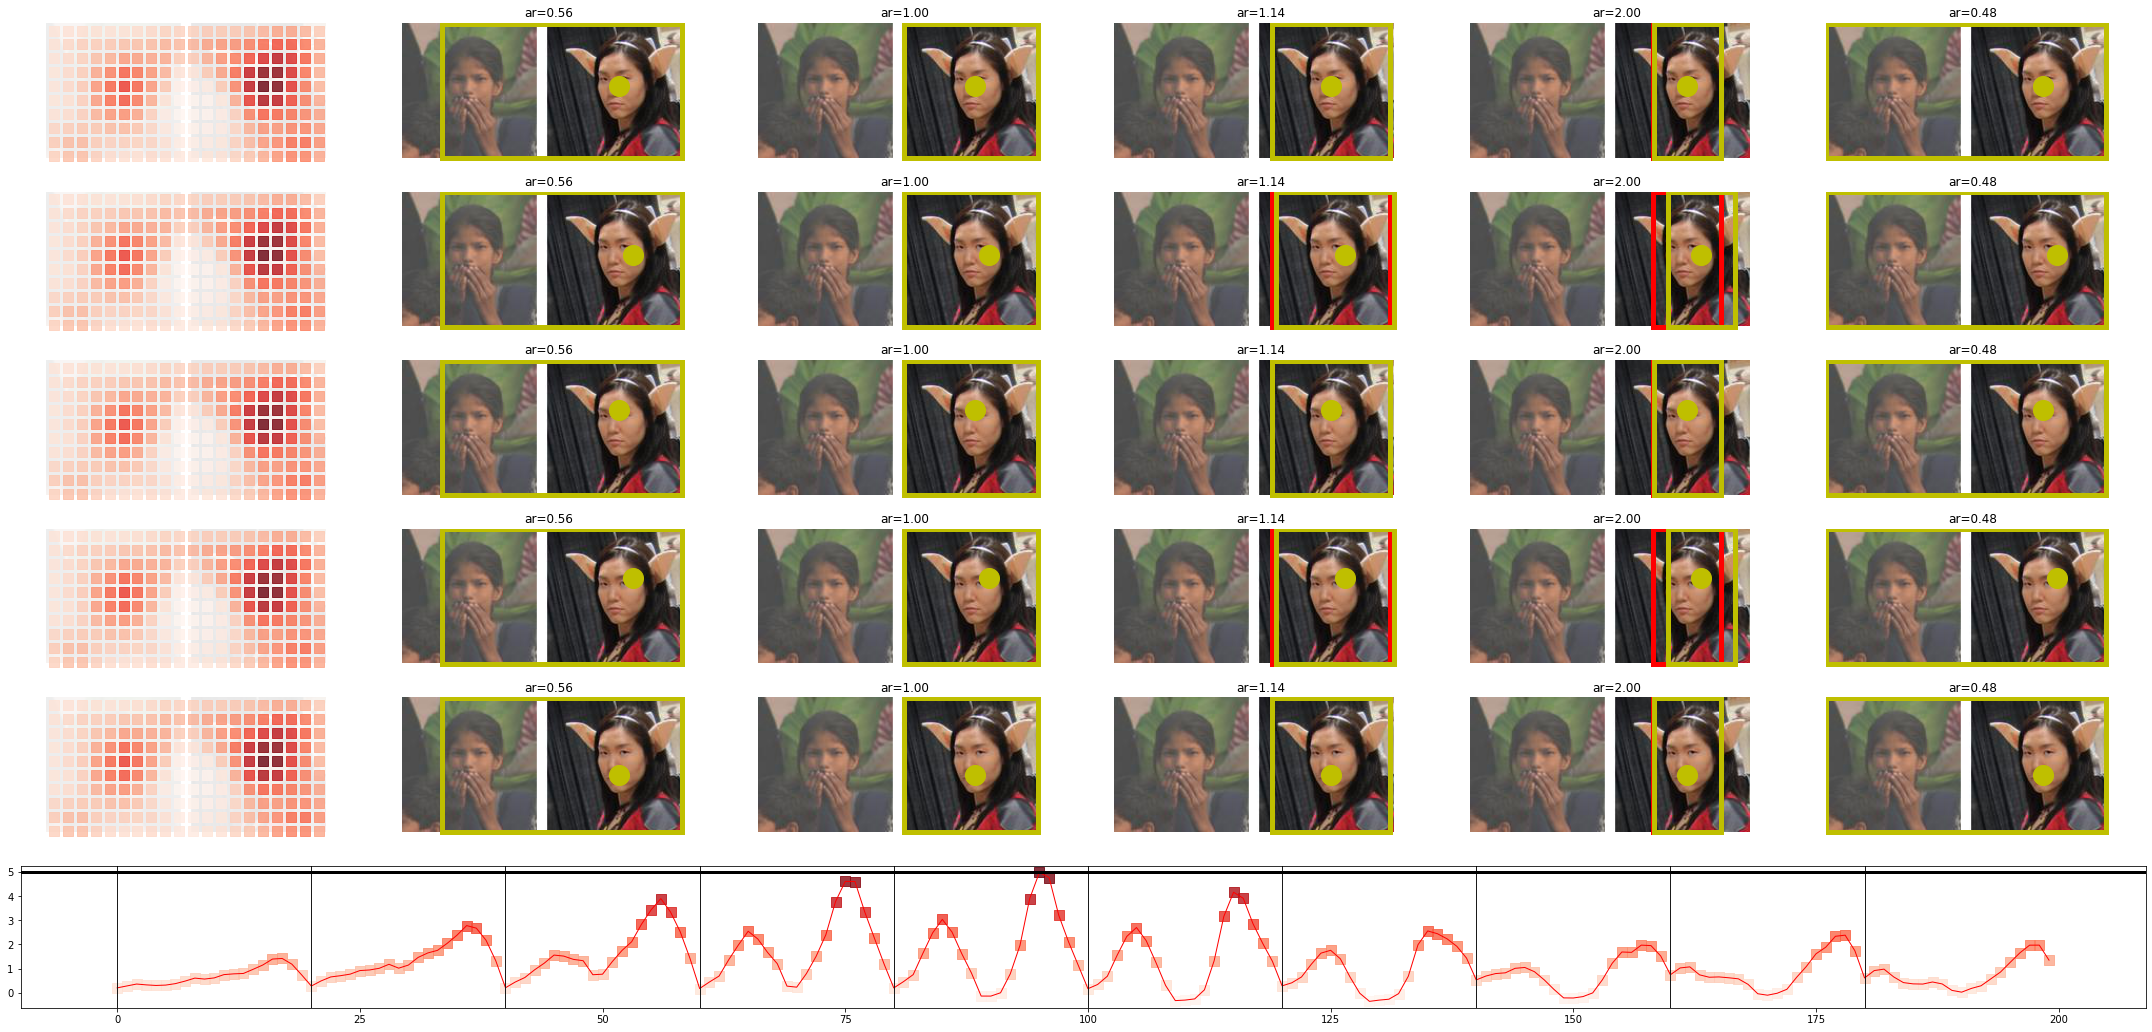

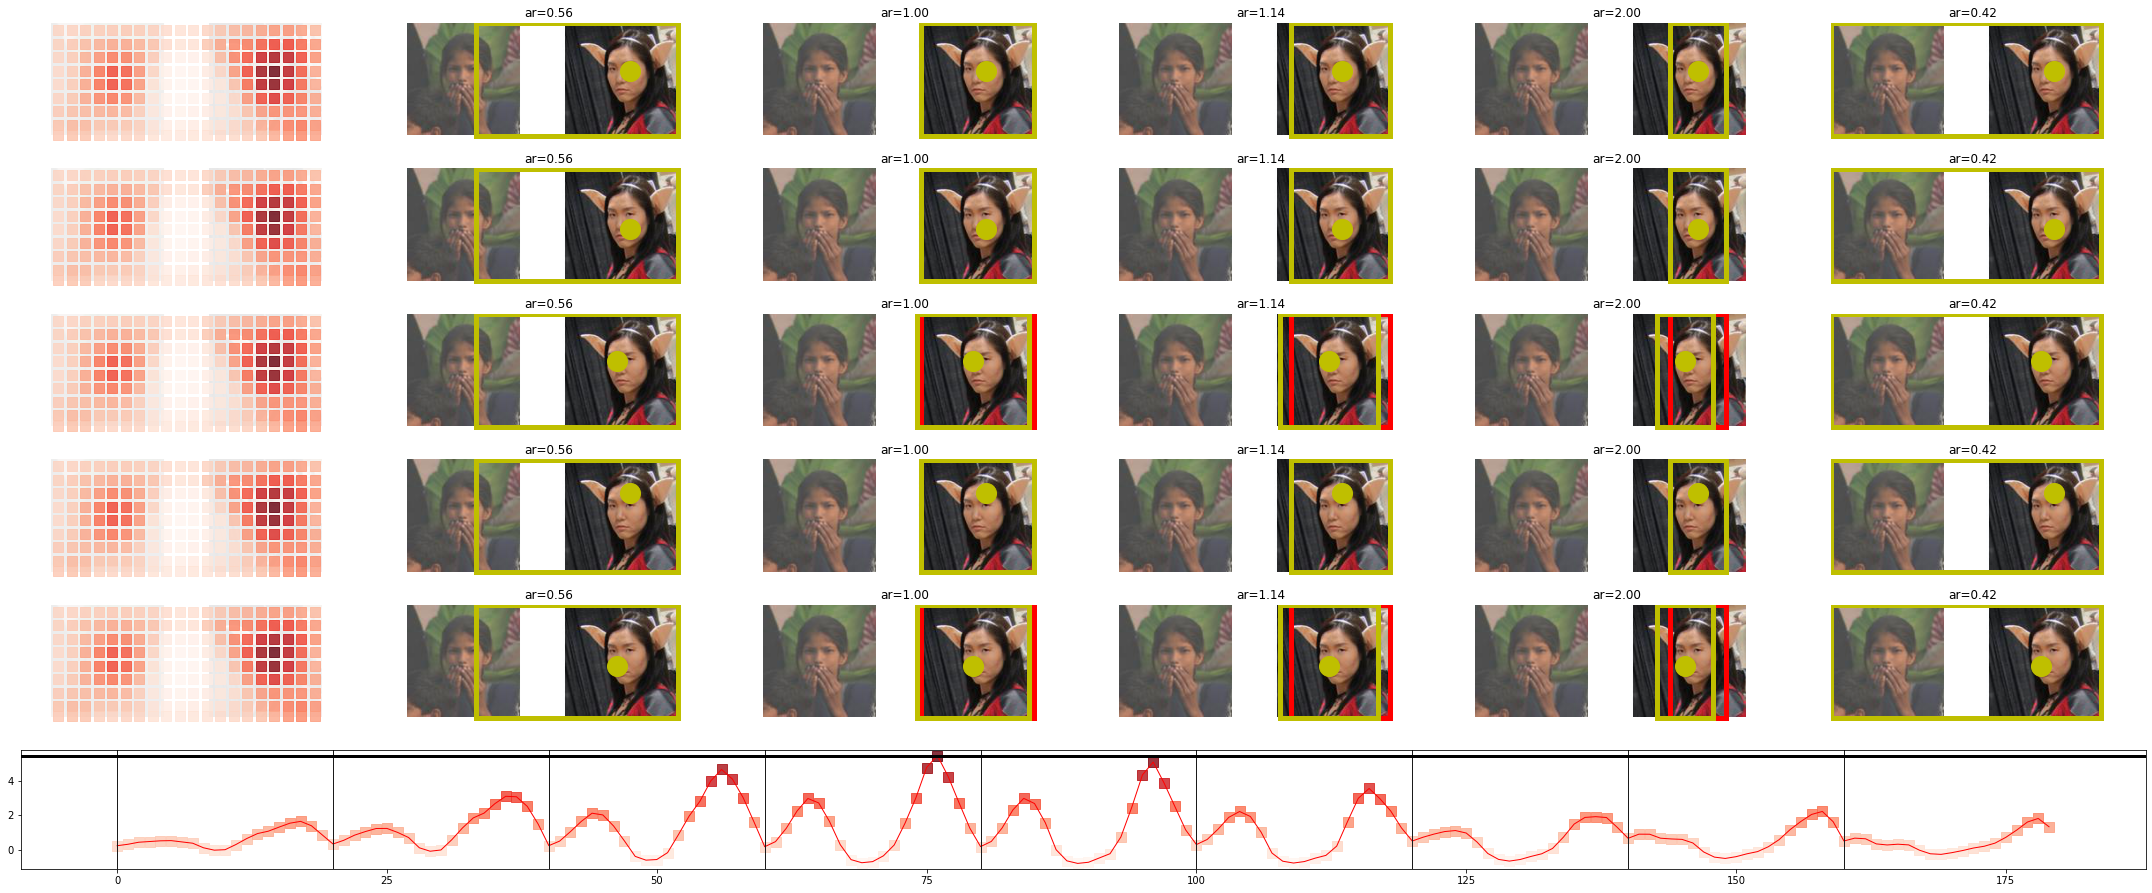

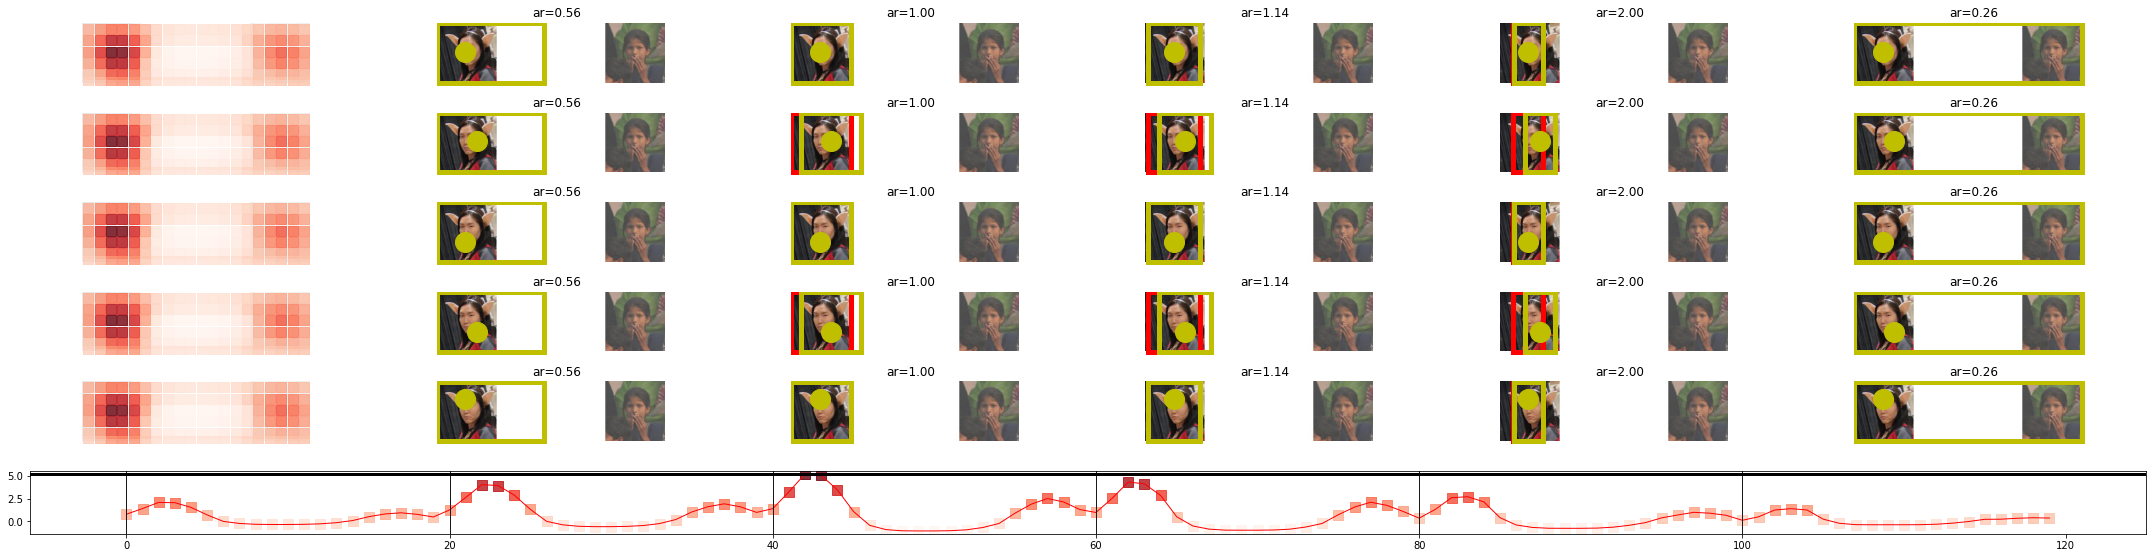

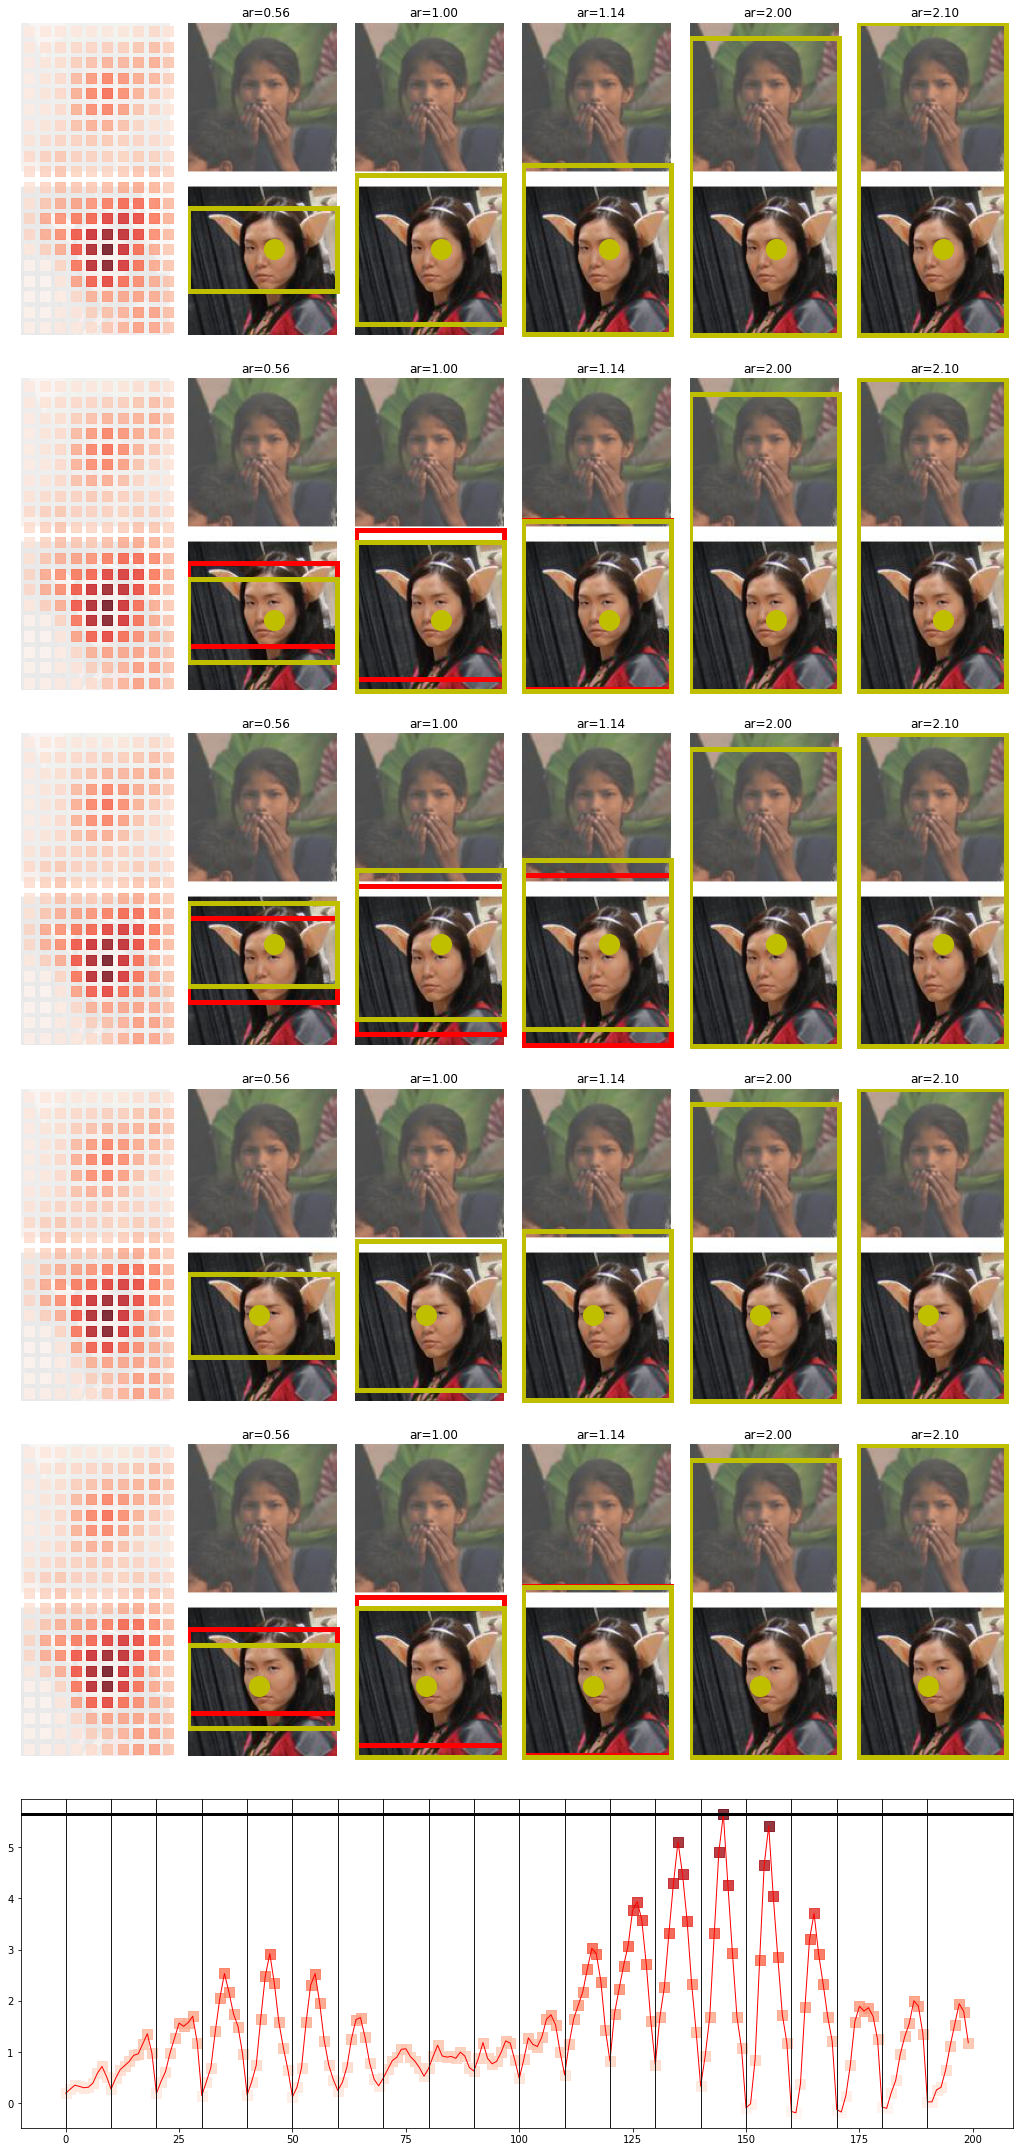

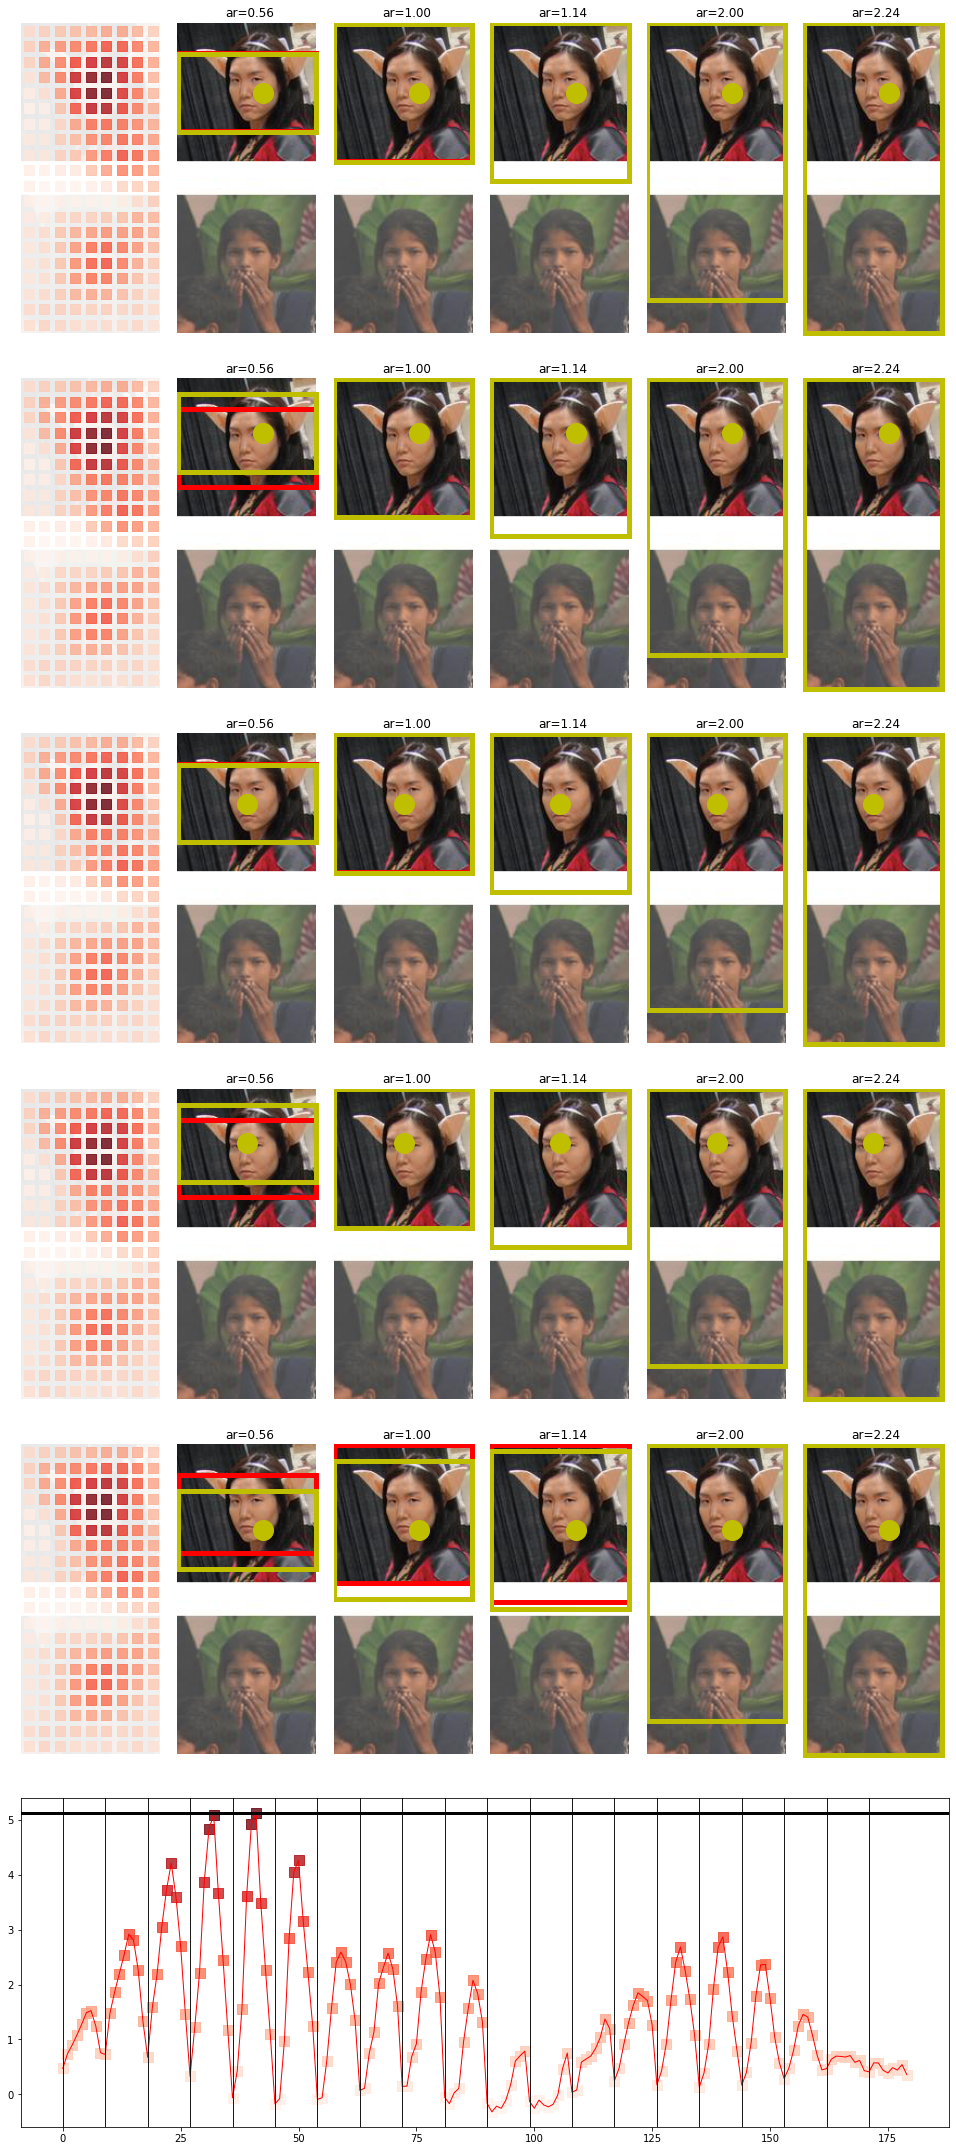

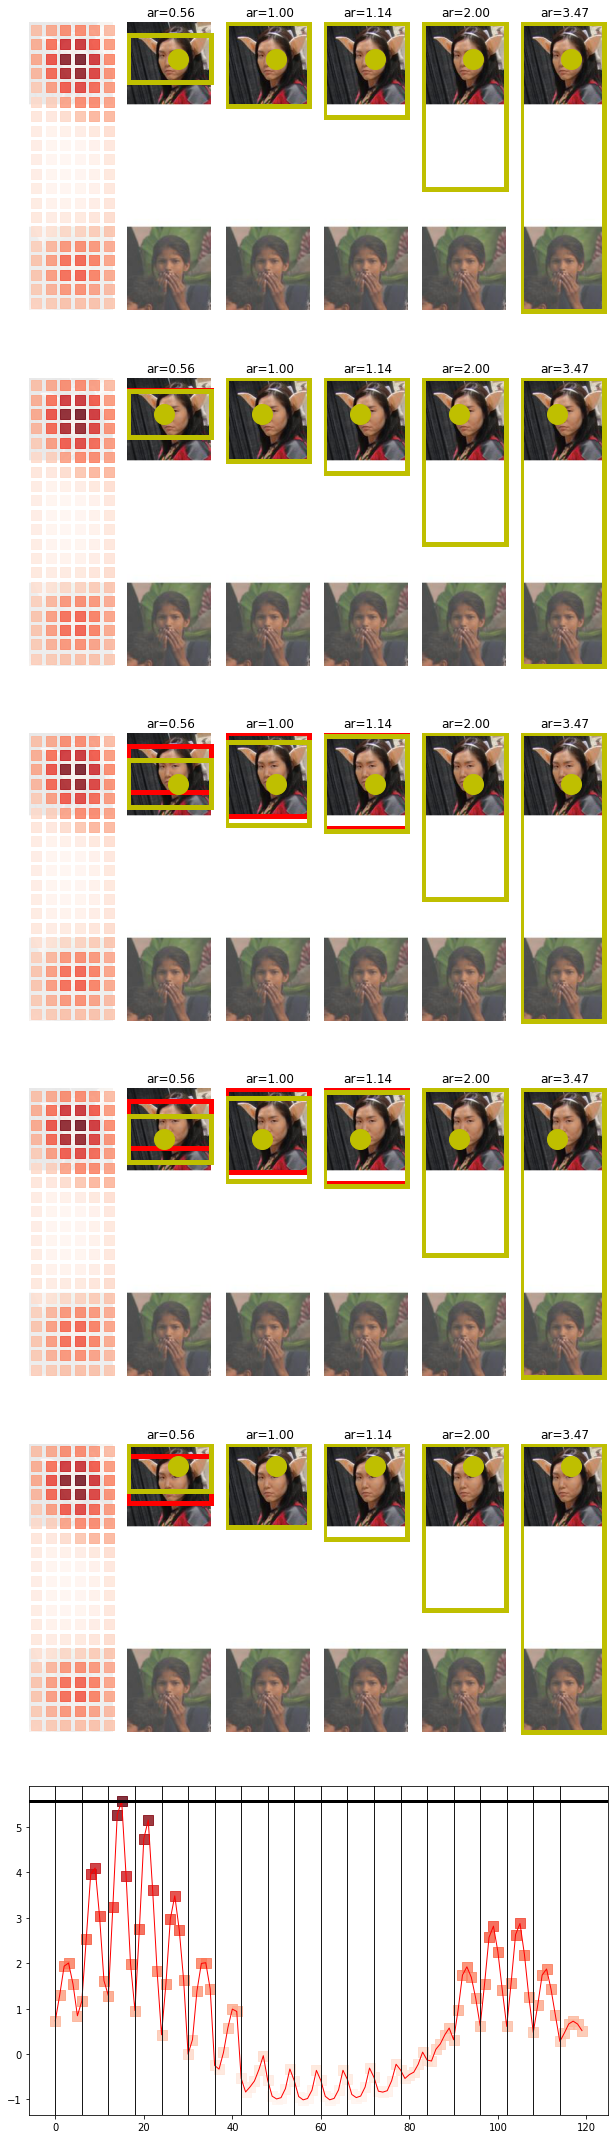

In [48]:
output_dir =f'{img_dir}/Twitter_saliency/FairFace_pairwise_tests/'
num_eval = 1
for i in range(len(padding_eval)):
  eval_key = list(padding_eval.keys())[i]
  label_id = eval_key
  if  eval_key == 'horizontal':
    label_id = 'h'
    num_cols = 2
  elif eval_key == 'vertical':
    label_id = 'v'
    num_cols = 1
  padding_blocks = padding_eval[eval_key]['padding_blocks'] 
  for j in range(len(padding_blocks)):
    for k in tqdm(range(num_eval)):
      instance_id = randomID_generator()
      image_files = glob.glob(str(data_dir / Path("./*.jpg")))
      random.SystemRandom().shuffle(image_files)
      images = [Image.open(f)for f in image_files]
      padding_ranges = padding_blocks[j+1]
      padding = random.SystemRandom().choice(range(padding_ranges['min'],
                                                   padding_ranges['max']))
      print(f'Using a padding value: {padding}')
      img = join_images(images, col_wrap=num_cols, img_size=(128,128),
                        padding=padding)
      filename = f'{instance_id}_{file_id}_p{padding}_t{k}_{label_id}'
      output_file = f"{output_dir}/{filename}.jpeg"
      img.save(output_file, "JPEG")
      model.plot_img_crops_using_img(img, topK=5, col_wrap=6)
      saliency_info = saliency_point_to_info(output_file, img_files, model, image_mode='horizontal')
      plt.savefig(f"{output_dir}/{filename}_sm.jpeg",bbox_inches="tight")

[0.56] 448 448


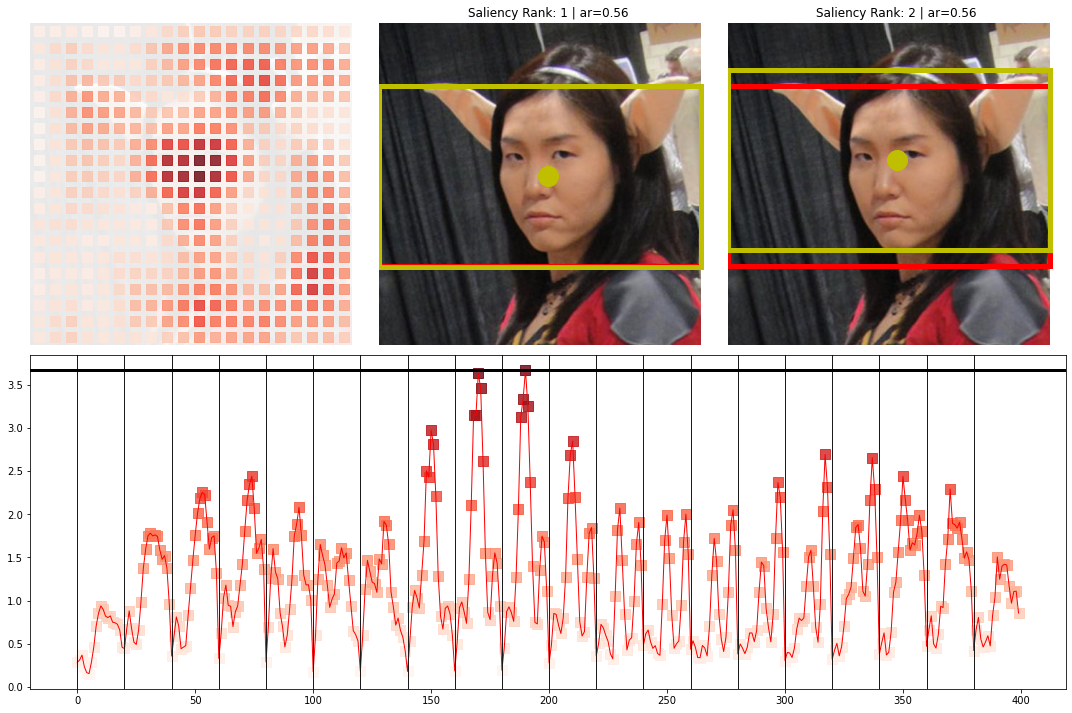

In [49]:
model.plot_img_crops(data_dir / Path(f"{img_id1}.jpg"), topK=2, aspectRatios=[0.56])
plt.savefig(f"{img_id1}_{img_race1}_{img_gender1}_saliency.jpeg", bbox_inches="tight")

[0.56] 448 448


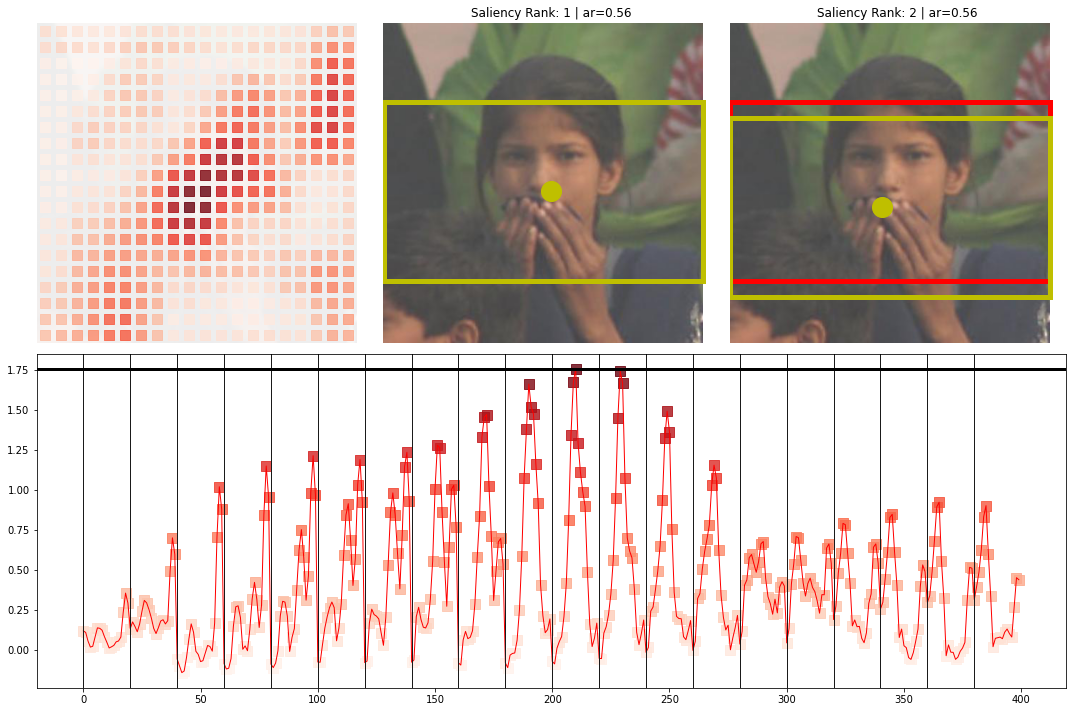

In [50]:
model.plot_img_crops(data_dir / Path(f"{img_id2}.jpg"), topK=2, aspectRatios=[0.56])
plt.savefig(f"{img_id2}_{img_race2}_{img_gender2}_saliency.jpeg", bbox_inches="tight")

# Randomized saliency filter testing for padding invariance

## Null hypothesis
**H₀** --> There are no differences between the baseline outputs of the saliency filter and the saliency filter outputs following randomized image paddings.

## Methodology for generating randomized image pairs from FairFace data
Randomization of the images for the pairwise comparisons are generated using the `random.SystemRandom()` class in the [Python **`random`** library](https://docs.python.org/3/library/random.html). 

The use of **`random.SystemRandom()`** class means, the exact image pairings are always dependent on the random numbers provided by the operating system sources. This method of random number generation is not available on all systems. Since this does not rely on the software state, the image pairing sequences are not reproducible. 

The goal of this experiment is to identify the existence of any statistical significant differences between the saliency filter outputs using baseline image pairs and the saliency filter outputs following randomized image padding. Therefore, the exact image pairing sequences used for the saliency filter output comparisons are immaterial for the reproducibility of this experiment.

In [51]:
num_pairwise_tests = 2
num_eval = 10
len(experiment_ids)

720

In [52]:
for _ in tqdm(range(num_pairwise_tests)):
  img_idx1,img_idx2 = random_imgID_generator(img_labels)  
  max_retries = 2000
  img_idx1, img_idx2 = img_pairs_filter(img_labels,img_idx1,img_idx2,
                                        max_retries=max_retries)
  img1_info,img2_info = img_info(img_labels, img_idx1, img_idx2)

  clear_image_history(unzip_dir)
  get_fairface_img(img_labels, img_idx1, unzip_dir, fairface_data)
  get_fairface_img(img_labels, img_idx2, unzip_dir, fairface_data)

  img_id1 = str(img_labels.iloc[img_idx1].file).split('/')[-1].replace('.jpg','')
  img_race1 = str(img_labels.iloc[img_idx1].race)
  img_gender1 = str(img_labels.iloc[img_idx1].gender)

  img_id2 = str(img_labels.iloc[img_idx2].file).split('/')[-1].replace('.jpg','')
  img_race2 = str(img_labels.iloc[img_idx2].race)
  img_gender2 = str(img_labels.iloc[img_idx2].gender)

  file_id = f'{img_id1}_{img_race1}_{img_gender1}--{img_id2}_{img_race2}_{img_gender2}'
  experiment_id = randomID_generator()

  image_files = glob.glob(str(data_dir / Path("./*.jpg")))

  output_dir =f'{img_dir}/Twitter_saliency/FairFace_pairwise_tests/'
  filename = f'{experiment_id}_{file_id}_p{padding}_t{k}_{label_id}'

  images = [Image.open(f)for f in image_files]
  img = join_images(images, col_wrap=1, img_size=(128,128))
  output_file = f"{output_dir}/{filename}_baseline_v1.jpeg"
  img.save(output_file, "JPEG")
  model.plot_img_crops_using_img(img, topK=5, col_wrap=6)
  baselinev1_saliency_info = saliency_point_to_info(Path(output_file).as_posix(), image_files, model, image_mode='vertical')
  plt.savefig(f"{output_dir}/{filename}_baseline_v1_sm.jpeg",bbox_inches="tight")
  plt.close()
  _=gc.collect()

  image_files.reverse()
  images = [Image.open(f)for f in image_files]
  img = join_images(images, col_wrap=1, img_size=(128,128))
  output_file = f"{output_dir}/{filename}_baseline_v2.jpeg"
  img.save(output_file, "JPEG")
  model.plot_img_crops_using_img(img, topK=5, col_wrap=6)
  baselinev2_saliency_info = saliency_point_to_info(Path(output_file).as_posix(), image_files, model, image_mode='vertical')
  plt.savefig(f"{output_dir}/{filename}_baseline_v2_sm.jpeg",bbox_inches="tight")
  plt.close()
  _=gc.collect()

  images = [Image.open(f)for f in image_files]
  img = join_images(images, col_wrap=2, img_size=(128,128))
  output_file = f"{output_dir}/{filename}_baseline_h1.jpeg"
  img.save(output_file, "JPEG")
  model.plot_img_crops_using_img(img, topK=5, col_wrap=6)
  baselineh1_saliency_info = saliency_point_to_info(Path(output_file).as_posix(), image_files, model, image_mode='horizontal')
  plt.savefig(f"{output_dir}/{filename}_baseline_h1_sm.jpeg",bbox_inches="tight")
  plt.close()
  _=gc.collect()

  image_files.reverse()
  images = [Image.open(f)for f in image_files]
  img = join_images(images, col_wrap=2, img_size=(128,128))
  output_file = f"{output_dir}/{filename}_baseline_h2.jpeg"
  img.save(output_file, "JPEG")
  model.plot_img_crops_using_img(img, topK=5, col_wrap=6)
  baselineh2_saliency_info = saliency_point_to_info(Path(output_file).as_posix(), image_files, model, image_mode='horizontal')
  plt.savefig(f"{output_dir}/{filename}_baseline_h2_sm.jpeg",bbox_inches="tight")
  plt.close()
  _=gc.collect()

  for i in range(len(padding_eval)):
    eval_key = list(padding_eval.keys())[i]
    label_id = eval_key
    if  eval_key == 'horizontal':
      label_id = 'h'
      num_cols = 2
    elif eval_key == 'vertical':
      label_id = 'v'
      num_cols = 1

    padding_blocks = padding_eval[eval_key]['padding_blocks'] 
    for j in range(len(padding_blocks)):
      for k in tqdm(range(num_eval)):
        instance_id = randomID_generator()
        random.SystemRandom().shuffle(image_files)
        images = [Image.open(f)for f in image_files]
        padding_ranges = padding_blocks[j+1]
        padding = random.SystemRandom().choice(range(padding_ranges['min'],
                                                     padding_ranges['max']))
        img = join_images(images, col_wrap=num_cols, img_size=(128,128),
                          padding=padding)
        filename = f'{instance_id}_{file_id}_p{padding}_t{k}_{label_id}'
        img.save(f"{output_dir}/{filename}.jpeg", "JPEG")
        model.plot_img_crops_using_img(img, topK=5, col_wrap=3)
        output_file = f"{output_dir}/{filename}_sm.jpeg"
        plt.savefig(output_file,bbox_inches="tight")
        saliency_info = saliency_point_to_info(Path(output_file).as_posix(), image_files, model, image_mode=eval_key)
        
        experiment_ids.append(experiment_id)
        instance_ids.append(instance_id)
        img1.append(img1_info)
        img2.append(img2_info)
        baseline_h1.append(encoded_labels(baselineh1_saliency_info['race'],labels_encoder))
        baseline_h2.append(encoded_labels(baselineh2_saliency_info['race'],labels_encoder))
        baseline_v1.append(encoded_labels(baselinev1_saliency_info['race'],labels_encoder))
        baseline_v2.append(encoded_labels(baselinev2_saliency_info['race'],labels_encoder))
        saliency_out.append(encoded_labels(saliency_info['race'],labels_encoder))
        combine_mode.append(eval_key)

        plt.close()
        _=gc.collect()

FairFace images 49015 and 58914 selected for evaluation using Twitter Saliency algorithm ...

/tmp/tmpdwuyp3yv
None 128 256
/tmp/tmpx69qtiz8
None 128 256
/tmp/tmp4qbkpili
None 256 128
/tmp/tmp38ff9jmu
None 256 128


/tmp/tmpzyofzpei
None 264 128
/tmp/tmpd31qdv0d
None 266 128
/tmp/tmpl54fubr_
None 257 128
/tmp/tmp9r0i7mi6
None 278 128
/tmp/tmp62jvnz9m
None 272 128
/tmp/tmp57dsbq8e
None 277 128
/tmp/tmpl555z9ra
None 272 128
/tmp/tmpddqlwjy3
None 258 128
/tmp/tmpwm00234o
None 264 128
/tmp/tmpqqo5ezom
None 278 128



/tmp/tmp6bi3o54h
None 320 128
/tmp/tmpjd6awh37
None 300 128
/tmp/tmpedvvfxch
None 303 128
/tmp/tmp59eiookl
None 308 128
/tmp/tmpy9utyzvb
None 295 128
/tmp/tmp2us_o43q
None 325 128
/tmp/tmpyqo1aukb
None 288 128
/tmp/tmpzb0deeq6
None 310 128
/tmp/tmpy1cdivy_
None 330 128
/tmp/tmpz64s8n31
None 295 128



/tmp/tmp64f7k_8k
None 459 128
/tmp/tmperdu1_02
None 467 128
/tmp/tmpvmt763bp
None 488 128
/tmp/tmps1yt6qwn
None 507 128
/tmp/tmp5o78z4se
None 382 128
/tmp/tmpgob4rlmd
None 546 128
/tmp/tmp1j9ydznq
None 456 128
/tmp/tmpye18pu0c
None 468 128
/tmp/tmpchx0hd4e
None 342 128
/tmp/tmp2wobqbxc
None 422 128



/tmp/tmptylzdu3v
None 128 268
/tmp/tmp1v60vs4j
None 128 269
/tmp/tmpz7b95ijm
None 128 268
/tmp/tmpm0zpt044
None 128 264
/tmp/tmpw1dxphom
None 128 266
/tmp/tmp6omzq1uz
None 128 259
/tmp/tmpwonv_mq8
None 128 268
/tmp/tmpg0ybfr5a
None 128 259
/tmp/tmp5t6j8w08
None 128 257
/tmp/tmpy5ongi_6
None 128 269



/tmp/tmpjqlvz_lz
None 128 306
/tmp/tmpmwvv73da
None 128 289
/tmp/tmp6omx6gvf
None 128 330
/tmp/tmpzuxyvb0t
None 128 303
/tmp/tmp9o9i9m3d
None 128 328
/tmp/tmpvmshrmrt
None 128 301
/tmp/tmp33kjjzlg
None 128 307
/tmp/tmpbn9dw5af
None 128 321
/tmp/tmp7wnp00li
None 128 321
/tmp/tmprjnbwkgj
None 128 290



/tmp/tmpt13bd0fj
None 128 434
/tmp/tmp6m7grxyf
None 128 375
/tmp/tmp40py6tj7
None 128 555
/tmp/tmpj0znmzl_
None 128 450
/tmp/tmp5cmfzhka
None 128 392
/tmp/tmp6_y1cssi
None 128 492
/tmp/tmpphc3fk8u
None 128 416
/tmp/tmpbnrh70fi
None 128 552
/tmp/tmp8adsclw3
None 128 494
/tmp/tmpqj8fbbdd
None 128 497

FairFace images 60228 and 71527 selected for evaluation using Twitter Saliency algorithm ...

/tmp/tmpjkkd8ll_
None 128 256
/tmp/tmp1phynrel
None 128 256
/tmp/tmpacjr5f9v
None 256 128
/tmp/tmpbqacdaff
None 256 128


/tmp/tmpxx8z18hl
None 275 128
/tmp/tmpeek321yc
None 277 128
/tmp/tmp2iokijf2
None 256 128
/tmp/tmp5omk3h3i
None 279 128
/tmp/tmpvgkfpk7s
None 276 128
/tmp/tmp8ey21_sv
None 275 128
/tmp/tmpibxvbofw
None 268 128
/tmp/tmpaiin18j3
None 266 128
/tmp/tmpgaxcu48j
None 273 128
/tmp/tmpmke2wn1i
None 269 128



/tmp/tmpebidczzu
None 290 128
/tmp/tmpc7ovemcp
None 290 128
/tmp/tmpuliofq98
None 302 128
/tmp/tmpatwgk749
None 314 128
/tmp/tmp4b4y_4pz
None 321 128
/tmp/tmpc2wg78ou
None 330 128
/tmp/tmpcx2_i8ej
None 283 128
/tmp/tmpqlegvli3
None 297 128
/tmp/tmpg40_eb_l
None 314 128
/tmp/tmp68e2jd2n
None 300 128



/tmp/tmpg0po5dx0
None 411 128
/tmp/tmp2vv8h7qt
None 350 128
/tmp/tmpcmmag5ig
None 360 128
/tmp/tmpbobnec2u
None 481 128
/tmp/tmp4vlmep61
None 369 128
/tmp/tmp5tul3did
None 546 128
/tmp/tmpphnvevkj
None 488 128
/tmp/tmp1zon9hz9
None 382 128
/tmp/tmp7aconnk9
None 333 128
/tmp/tmp_4a6sool
None 551 128



/tmp/tmppd811aes
None 128 264
/tmp/tmpdsrudgoj
None 128 266
/tmp/tmp2p3468xj
None 128 266
/tmp/tmpx5w322kj
None 128 257
/tmp/tmpwiwxlz5k
None 128 272
/tmp/tmp_sglcvau
None 128 269
/tmp/tmpbtd3nw3m
None 128 275
/tmp/tmp1zn8u_ar
None 128 277
/tmp/tmp5po26i9m
None 128 257
/tmp/tmpi5yic3n9
None 128 271



/tmp/tmpg57hool3
None 128 313
/tmp/tmpsgl7wgot
None 128 318
/tmp/tmpgw685piz
None 128 329
/tmp/tmpzrl5vquq
None 128 288
/tmp/tmp3y1v5xv5
None 128 306
/tmp/tmp78o6bx26
None 128 291
/tmp/tmppwv_2_74
None 128 304
/tmp/tmpd_76lq1n
None 128 306
/tmp/tmp3u51pm43
None 128 288
/tmp/tmp5h239hty
None 128 329



/tmp/tmp2_jiw_58
None 128 483
/tmp/tmpfvj14ukx
None 128 462
/tmp/tmpcmufmm9r
None 128 553
/tmp/tmp0brm7zph
None 128 416
/tmp/tmp3b3xmt29
None 128 363
/tmp/tmppx4vrduy
None 128 458
/tmp/tmpux1r7a8x
None 128 360
/tmp/tmpgealxnq6
None 128 389
/tmp/tmp4i1vzuf3
None 128 476
/tmp/tmpqi9x7zik
None 128 346




In [53]:
len(experiment_ids)

840

In [54]:
pairwise_df = pd.DataFrame()

In [55]:
pairwise_df['experiment_id']= experiment_ids
pairwise_df['instance_id']=instance_ids
pairwise_df['img1']=img1
pairwise_df['img2']=img2
pairwise_df['baseline_h1']=baseline_h1
pairwise_df['baseline_h2']=baseline_h2
pairwise_df['baseline_v1']=baseline_v1
pairwise_df['baseline_v2']=baseline_v2
pairwise_df['saliency_out']=saliency_out
pairwise_df['combine_mode']=combine_mode 

In [56]:
print(len(pairwise_df))

840


# Save experiment history

In [57]:
pairwise_df.to_csv(pairwise_tests_data)

In [58]:
print(len(pairwise_df))
print(pairwise_df.head())
print(pairwise_df.tail())

840
  experiment_id instance_id  ... saliency_out combine_mode
0      WI2dbkut    hYWUKfXO  ...            0   horizontal
1      WI2dbkut    euvg1ilz  ...            0   horizontal
2      WI2dbkut    hD5B4ZF3  ...            1   horizontal
3      WI2dbkut    CH8SRoxa  ...            0   horizontal
4      WI2dbkut    07fzHCDu  ...            0   horizontal

[5 rows x 10 columns]
    experiment_id instance_id  ... saliency_out combine_mode
835      szxbdypZ    U0jWvsYh  ...            6     vertical
836      szxbdypZ    0DgOyE5h  ...            3     vertical
837      szxbdypZ    cVhfmorp  ...            3     vertical
838      szxbdypZ    bsipRBlD  ...            6     vertical
839      szxbdypZ    jeru08at  ...            3     vertical

[5 rows x 10 columns]


# Calculate statistical significance

[Wilcoxon signed rank test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test) is used to calculate whether there are any statistically significant differences between the baseline saliency filter outputs and the saliency filter outputs following image padding. The Wilcoxon signed rank test is performed using the [SciPy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html).

In [59]:
w, p = wilcoxon(pairwise_df['baseline_h2']-pairwise_df['saliency_out'])
print(w,p)
w, p = wilcoxon(pairwise_df['baseline_h1']-pairwise_df['saliency_out'])
print(w,p)
w, p = wilcoxon(pairwise_df['baseline_v2']-pairwise_df['saliency_out'])
print(w,p)
w, p = wilcoxon(pairwise_df['baseline_v1']-pairwise_df['saliency_out'])
print(w,p)

27909.0 2.8561869063533102e-11
27909.0 2.8561869063533102e-11
27909.0 2.8561869063533102e-11
27909.0 2.8561869063533102e-11
